# 0. Imports & inputs & introductions

This files is written to compare the data sent from James Sturch to compare the mismatch results using Solar Edge system. The email was sent by Jame Sturch and the date was 20/11/2024.

In [1]:
# imports
import os
import sys
import time
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pvlib
import imageio
import datetime
from datetime import timedelta
import scipy.constants as const
import matplotlib.dates as mdates


# data folder direcotry
data_dir = r"C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Data"
# direrctory for saving results
base_dir = r"C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results"
# directory for the results folder to investigate for session 6
results_dir = r'C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\iv_curve_plots_20250404_211059_spring_3794347'

# Define the site to read
# site_id = '1398284'  # Site identifier
# site_id = '347166'
# site_id = '4129142'
# site_id = '3499407'
# site_id = '378878'
# site_id = '3794347'
# site_id = '3996237'
site_id = '3455043'


# define the season
# season = 'summer'
season = 'spring'
# season = 'winter'
# season = 'autumn'

# define the module parameter
# ideality_factor = 0.954526056
# num_cells_series = 120
# thermal_voltage_25C = 0.0258
# series_resistance = 0.229
# shunt_resistance = 300

if site_id == '347166':
    ideality_factor = 1.0081
    num_cells_series = 60
    thermal_voltage_25C = 0.0258
    series_resistance = 0.302
    shunt_resistance = 400
elif site_id == '1398284':
    ideality_factor = 0.954526056
    num_cells_series = 120
    thermal_voltage_25C = 0.0258
    series_resistance = 0.229
    shunt_resistance = 300
elif site_id == '4129142':
    ideality_factor = 1.029
    num_cells_series = 72
    thermal_voltage_25C = 0.0258
    series_resistance = 0.269
    shunt_resistance = 600
elif site_id == '3499407':
    ideality_factor = 1.03
    num_cells_series = 72
    thermal_voltage_25C = 0.0258
    series_resistance = 0.29
    shunt_resistance = 350
elif site_id == '378878':
    ideality_factor = 0.994
    num_cells_series = 60
    thermal_voltage_25C = 0.0258
    series_resistance = 0.176
    shunt_resistance = 1000
elif site_id == '3794347':
    ideality_factor = 1.039
    num_cells_series = 54*2
    thermal_voltage_25C = 0.0258
    series_resistance = 0.133
    shunt_resistance = 1200
elif site_id == '3996237':
    ideality_factor = 1.025
    num_cells_series = 54*2
    thermal_voltage_25C = 0.0258
    series_resistance = 0.161
    shunt_resistance = 260

# Determine fixed x and y axis limits for all plots that plot for each module
y_limit_module = (0, 15)
x_limit_module = (0, 60)  # Assuming a reasonable range for combined voltages

# Determine fixed x and y axis limits for all plots that plot for the combined inverter
y_limit_inverter = (0, 15)
x_limit_inverter = (0, 1000)  # Adjust for combined voltages

# Option to dynamically calculate vth based on panel temperature
use_dynamic_vth = False  # Set to True to enable dynamic calculation, False to use thermal_voltage_25C

# Option to replace the panel temperature with the temperature, the reason to do this is that the module temperature looks too high but the ambient tmperature looks like module temperature
use_a_T = True  # Set to True to use ambient temperature, False to use module temperature

In [2]:
# define the function to calculate the I0 at MPPT
def I0(I, V, Rs, Rsh, n, N, vth):
    # calculate the exponential term
    exp_term = np.exp(-(V + I * Rs) / (n * N * vth))
    # calculate the fraction term
    frac_term = n * N * vth / V
    # calculate hte numerator
    numerator = I*(1 + Rs/Rsh) - V/Rsh
    # calculate the denominator
    denominator = 1 - I * Rs / V
    # put them together
    I0 = numerator / denominator * frac_term * exp_term
    return I0

# define the function to calculate IL at MPPT
def IL(I, V, Rs, Rsh, n, N, vth, I0):
    # calculate the first term
    first_term = I * (1 + Rs/Rsh)
    # calculate the second term
    second_term = V / Rsh
    # calculate the third term
    third_term = I0*(np.exp((V + I * Rs) / (n * N * vth)) - 1)
    # put them together
    IL = first_term + second_term + third_term
    return IL


# 1. Read & visualise

## 1.1. Find the site folder

In [3]:
# Find the directory containing the site_id
site_dir = [d for d in os.listdir(data_dir) if site_id in d][0]

# Full path to the site directory
site_dir = os.path.join(data_dir, site_dir)

print(f"Reading data from {site_dir}")

Reading data from C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Data\3455043


## 1.2. Season data extraction

### 1.2.1. Data extraction

In [4]:
# Define a mapping from season to a list of month names (all in lowercase)
season_months = {
    'summer': ['december', 'january', 'february'],
    'autumn': ['march', 'april', 'may'],
    'winter': ['june', 'july', 'august'],
    'spring': ['september', 'october', 'november']
}

# Ensure the season is in lowercase for matching
season_lower = season.lower()

# Find the folder that contains the season word or any month name corresponding to that season
season_dir_candidates = [
    d for d in os.listdir(site_dir)
    if (season_lower in d.lower() or any(month in d.lower() for month in season_months.get(season_lower, [])))
]

if not season_dir_candidates:
    raise ValueError("No folder found that contains the specified season or its corresponding months.")

# Choose the first matching folder (or adjust the selection logic as needed)
season_dir = season_dir_candidates[0]

# Full path to the season directory
season_dir = os.path.join(site_dir, season_dir)
print("Season directory found:", season_dir)

# Initialize empty lists to store the DataFrames and reporter IDs
dataframes = []
reporter_ids = []

# Define a list of potential timestamp formats
timestamp_formats = [
    "%Y-%m-%d %H:%M:%S",
    "%d/%m/%Y %H:%M",
    "%m/%d/%Y %H:%M",
    "%Y-%d-%m %H:%M:%S",
    None  # Let pandas infer formats
]

# Get a list of CSV files in the season directory that contain "optimizer_data"
csv_files = [f for f in os.listdir(season_dir) if 'optimizer_data' in f and f.endswith('.csv')]

if not csv_files:
    raise ValueError("No CSV files found in season directory.")

# If only one CSV file exists, check if it contains a 'reporter_id' column.
if len(csv_files) == 1:
    file = csv_files[0]
    file_path = os.path.join(season_dir, file)
    df = pd.read_csv(file_path)
    
    if 'reporter_id' in df.columns:
        # Process the single CSV file by splitting it by reporter_id.
        unique_reporters = df['reporter_id'].unique()
        for reporter in unique_reporters:
            df_rep = df[df['reporter_id'] == reporter].copy()
            # Rename the first column to "Timestamp" if not already
            if df_rep.columns[0] != 'Timestamp':
                df_rep.rename(columns={df_rep.columns[0]: 'Timestamp'}, inplace=True)
            
            # Define a mapping for renaming relevant columns to include the reporter id
            rename_map = {
                'panel_current': f'panel_current_{reporter}',
                'panel_voltage': f'panel_voltage_{reporter}',
                'temperature': f'temperature_{reporter}',
                'panel_temperature': f'panel_temperature_{reporter}',
                'power': f'power_{reporter}'
            }
            df_rep.rename(columns=rename_map, inplace=True)
            
            # Convert the "Timestamp" column to datetime using potential formats
            for fmt in timestamp_formats:
                try:
                    df_rep['Timestamp'] = pd.to_datetime(df_rep['Timestamp'], format=fmt)
                    break
                except (ValueError, TypeError):
                    pass
            
            # Set the index to the Timestamp
            df_rep.set_index('Timestamp', inplace=True)
            # Keep only the renamed columns
            df_rep = df_rep[list(rename_map.values())]
            dataframes.append(df_rep)
            reporter_ids.append(str(reporter))
    else:
        # Single CSV file but without a 'reporter_id' column.
        # Treat the entire file as coming from a default reporter.
        default_reporter = "default"
        if df.columns[0] != 'Timestamp':
            df.rename(columns={df.columns[0]: 'Timestamp'}, inplace=True)
        rename_map = {
            'panel_current': f'panel_current_{default_reporter}',
            'panel_voltage': f'panel_voltage_{default_reporter}',
            'temperature': f'temperature_{default_reporter}',
            'panel_temperature': f'panel_temperature_{default_reporter}',
            'power': f'power_{default_reporter}'
        }
        df.rename(columns=rename_map, inplace=True)
        for fmt in timestamp_formats:
            try:
                df['Timestamp'] = pd.to_datetime(df['Timestamp'], format=fmt)
                break
            except (ValueError, TypeError):
                pass
        df.set_index('Timestamp', inplace=True)
        df = df[list(rename_map.values())]
        dataframes.append(df)
        reporter_ids.append(default_reporter)
else:
    # Multiple CSV files case (each file corresponding to one optimizer)
    for file in csv_files:
        file_path = os.path.join(season_dir, file)
        optimizer_data = pd.read_csv(file_path)
        
        # Extract the reporter_id from the file name (assuming it is the last part before the extension)
        reporter_id = file.split('_')[-1].split('.')[0]
        reporter_ids.append(reporter_id)
        
        optimizer_data.rename(columns={
            'panel_current': f'panel_current_{reporter_id}',
            'panel_voltage': f'panel_voltage_{reporter_id}',
            'temperature': f'temperature_{reporter_id}',
            'panel_temperature': f'panel_temperature_{reporter_id}',
            'power': f'power_{reporter_id}'
        }, inplace=True)
        
        if optimizer_data.columns[0] != 'Timestamp':
            optimizer_data.rename(columns={optimizer_data.columns[0]: 'Timestamp'}, inplace=True)
        
        for fmt in timestamp_formats:
            try:
                optimizer_data['Timestamp'] = pd.to_datetime(optimizer_data['Timestamp'], format=fmt)
                break
            except (ValueError, TypeError):
                pass
        
        optimizer_data.set_index('Timestamp', inplace=True)
        optimizer_data = optimizer_data[[f'panel_current_{reporter_id}', f'panel_voltage_{reporter_id}',
                                         f'temperature_{reporter_id}', f'panel_temperature_{reporter_id}',
                                         f'power_{reporter_id}']]
        dataframes.append(optimizer_data)

# Synchronize timestamps across all DataFrames:
if dataframes:
    # Find the overlapping time window by using the maximum start time and the minimum end time.
    earliest_timestamp = max([df.index[0] for df in dataframes])
    latest_timestamp = min([df.index[-1] for df in dataframes])
    # Create a new index with a 5-minute frequency.
    new_index = pd.date_range(start=earliest_timestamp, end=latest_timestamp, freq='5T')
    
    # Reindex each DataFrame, inserting NaN for missing timestamps.
    for i in range(len(dataframes)):
        for index in new_index:
            if index not in dataframes[i].index:
                dataframes[i].loc[index] = np.nan
    
    # Merge all DataFrames on the Timestamp index.
    merged_data = pd.concat(dataframes, axis=1)
    # Reset the index so that Timestamp becomes a column.
    merged_data.reset_index(inplace=True)

if use_a_T:
    print("Using ambient temperature")
    # Remove any column whose name contains "panel_temperature"
    cols_to_drop = [col for col in merged_data.columns if 'panel_temperature' in col]
    merged_data.drop(columns=cols_to_drop, inplace=True)
    
    # For each column that contains "temperature", create a duplicate column 
    # with the name changed from "temperature" to "panel_temperature"
    for col in [col for col in merged_data.columns if 'temperature' in col]:
        new_col = col.replace('temperature', 'panel_temperature')
        merged_data[new_col] = merged_data[col]
    
print(merged_data)


Season directory found: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Data\3455043\september
Using ambient temperature
               Timestamp  panel_current_226780324  panel_voltage_226780324  \
0    2024-09-20 05:45:00                      NaN                      NaN   
1    2024-09-20 05:50:00                      NaN                      NaN   
2    2024-09-20 05:55:00                 0.107708                31.586310   
3    2024-09-20 06:00:00                 0.148265                31.744983   
4    2024-09-20 06:05:00                 0.208990                33.404110   
...                  ...                      ...                      ...   
2733 2024-09-29 17:30:00                 0.167100                30.680203   
2734 2024-09-29 17:35:00                 0.121352                30.142023   
2735 2024-09-29 17:40:00                 0.081226                29.704280   
2736 2024-09-29 17:45:00                 0.062500                29.500000   
2737 2024-09-2

### 1.2.2. Visualisation

#### 1.2.2.1. Include temperature

               Timestamp  panel_current_226780324  panel_voltage_226780324  \
0    2024-09-20 05:45:00                      NaN                      NaN   
1    2024-09-20 05:50:00                      NaN                      NaN   
2    2024-09-20 05:55:00                 0.107708                31.586310   
3    2024-09-20 06:00:00                 0.148265                31.744983   
4    2024-09-20 06:05:00                 0.208990                33.404110   
...                  ...                      ...                      ...   
2733 2024-09-29 17:30:00                 0.167100                30.680203   
2734 2024-09-29 17:35:00                 0.121352                30.142023   
2735 2024-09-29 17:40:00                 0.081226                29.704280   
2736 2024-09-29 17:45:00                 0.062500                29.500000   
2737 2024-09-29 17:50:00                      NaN                      NaN   

      temperature_226780324  power_226780324  panel_current_226

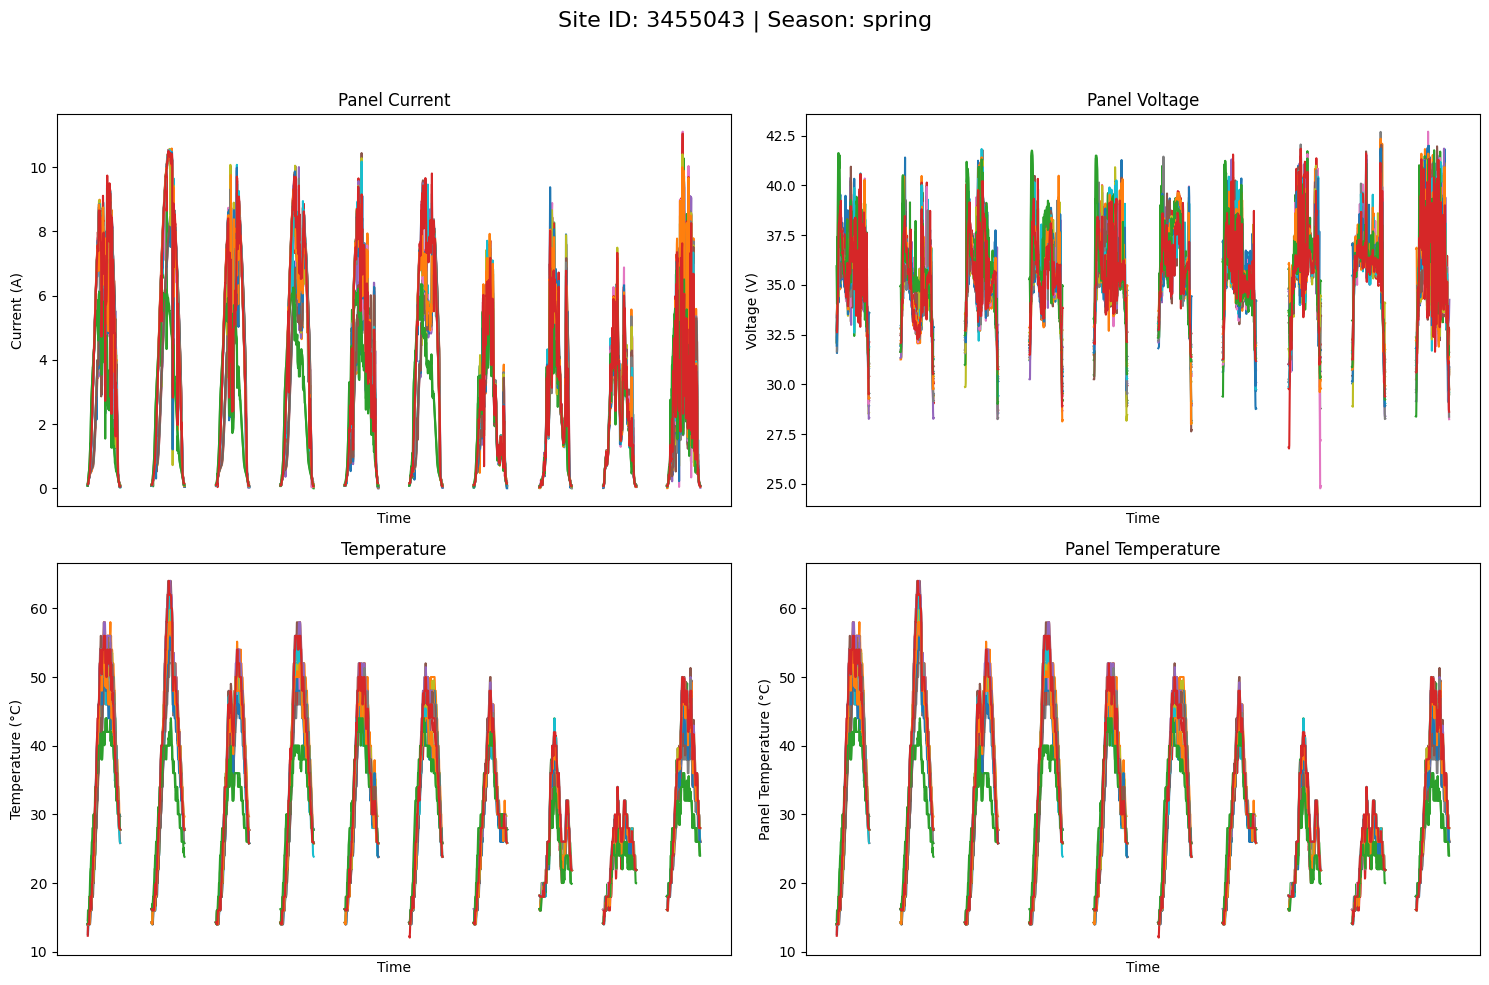

In [5]:
# Specify the number of days to plot
num_days_to_plot = 10

# Filter the data for the specified number of days
start_date = pd.to_datetime(merged_data['Timestamp'].iloc[0])
end_date = start_date + timedelta(days=num_days_to_plot)
filtered_data = merged_data[(pd.to_datetime(merged_data['Timestamp']) >= start_date) & 
                            (pd.to_datetime(merged_data['Timestamp']) < end_date)]

print(filtered_data)

# Create a 2x2 subplot for the data
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Add a figure-level title with site ID and season
fig.suptitle(f"Site ID: {site_id} | Season: {season}", fontsize=16)

# Plot all panel currents
for reporter_id in reporter_ids:
    axs[0, 0].plot(filtered_data['Timestamp'], filtered_data[f'panel_current_{reporter_id}'])
axs[0, 0].set_title('Panel Current')
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('Current (A)')
axs[0, 0].tick_params(axis='x', which='both', bottom=False, labelbottom=False)  # Remove x-ticks

# Plot all panel voltages
for reporter_id in reporter_ids:
    axs[0, 1].plot(filtered_data['Timestamp'], filtered_data[f'panel_voltage_{reporter_id}'])
axs[0, 1].set_title('Panel Voltage')
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('Voltage (V)')
axs[0, 1].tick_params(axis='x', which='both', bottom=False, labelbottom=False)  # Remove x-ticks

# Plot all temperatures
for reporter_id in reporter_ids:
    axs[1, 0].plot(filtered_data['Timestamp'], filtered_data[f'temperature_{reporter_id}'])
axs[1, 0].set_title('Temperature')
axs[1, 0].set_xlabel('Time')
axs[1, 0].set_ylabel('Temperature (°C)')
axs[1, 0].tick_params(axis='x', which='both', bottom=False, labelbottom=False)  # Remove x-ticks

# Plot all panel temperatures
for reporter_id in reporter_ids:
    axs[1, 1].plot(filtered_data['Timestamp'], filtered_data[f'panel_temperature_{reporter_id}'])
axs[1, 1].set_title('Panel Temperature')
axs[1, 1].set_xlabel('Time')
axs[1, 1].set_ylabel('Panel Temperature (°C)')
axs[1, 1].tick_params(axis='x', which='both', bottom=False, labelbottom=False)  # Remove x-ticks

# Adjust layout and show the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the suptitle
plt.show()


#### 1.2.2.2. Exclude temperature

               Timestamp  panel_current_226780324  panel_voltage_226780324  \
0    2024-09-20 05:45:00                      NaN                      NaN   
1    2024-09-20 05:50:00                      NaN                      NaN   
2    2024-09-20 05:55:00                 0.107708                31.586310   
3    2024-09-20 06:00:00                 0.148265                31.744983   
4    2024-09-20 06:05:00                 0.208990                33.404110   
...                  ...                      ...                      ...   
2733 2024-09-29 17:30:00                 0.167100                30.680203   
2734 2024-09-29 17:35:00                 0.121352                30.142023   
2735 2024-09-29 17:40:00                 0.081226                29.704280   
2736 2024-09-29 17:45:00                 0.062500                29.500000   
2737 2024-09-29 17:50:00                      NaN                      NaN   

      temperature_226780324  power_226780324  panel_current_226

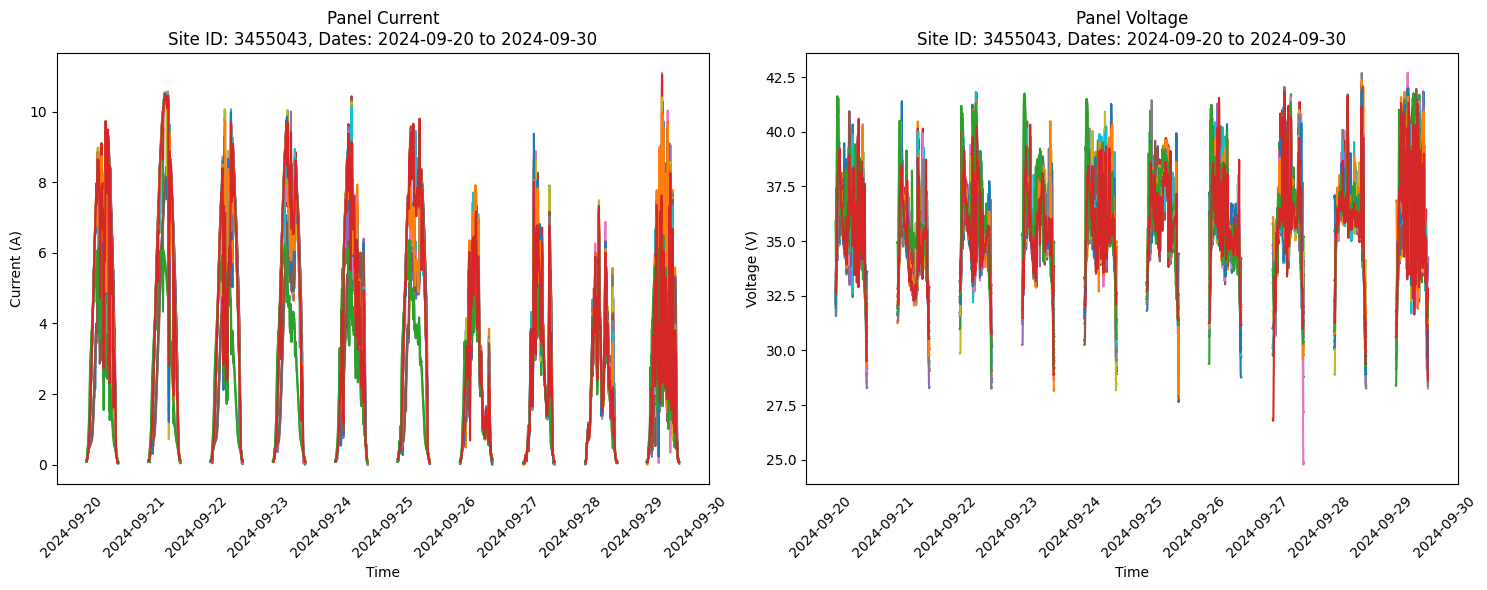

In [6]:
# Specify the number of days to plot
num_days_to_plot = 10

# Filter the data for the specified number of days
start_date = pd.to_datetime(merged_data['Timestamp'].iloc[0])
end_date = start_date + timedelta(days=num_days_to_plot)
filtered_data = merged_data[(pd.to_datetime(merged_data['Timestamp']) >= start_date) & 
                            (pd.to_datetime(merged_data['Timestamp']) < end_date)]

print(filtered_data)

# Create a 1x2 subplot for panel current and panel voltage
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Format the date range for the title
date_range_str = f"{start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}"

# Plot all panel currents
for reporter_id in reporter_ids:
    axs[0].plot(filtered_data['Timestamp'], filtered_data[f'panel_current_{reporter_id}'], label=f'Panel {reporter_id}')
axs[0].set_title(f'Panel Current\nSite ID: {site_id}, Dates: {date_range_str}')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Current (A)')
axs[0].tick_params(axis='x', which='both', bottom=False, labelrotation=45)

# Plot all panel voltages
for reporter_id in reporter_ids:
    axs[1].plot(filtered_data['Timestamp'], filtered_data[f'panel_voltage_{reporter_id}'], label=f'Panel {reporter_id}')
axs[1].set_title(f'Panel Voltage\nSite ID: {site_id}, Dates: {date_range_str}')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Voltage (V)')
axs[1].tick_params(axis='x', which='both', bottom=False, labelrotation=45)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


#### 1.2.2.3. Individual plots

               Timestamp  panel_current_226780324  panel_voltage_226780324  \
0    2024-09-20 05:45:00                      NaN                      NaN   
1    2024-09-20 05:50:00                      NaN                      NaN   
2    2024-09-20 05:55:00                 0.107708                31.586310   
3    2024-09-20 06:00:00                 0.148265                31.744983   
4    2024-09-20 06:05:00                 0.208990                33.404110   
...                  ...                      ...                      ...   
2733 2024-09-29 17:30:00                 0.167100                30.680203   
2734 2024-09-29 17:35:00                 0.121352                30.142023   
2735 2024-09-29 17:40:00                 0.081226                29.704280   
2736 2024-09-29 17:45:00                 0.062500                29.500000   
2737 2024-09-29 17:50:00                      NaN                      NaN   

      temperature_226780324  power_226780324  panel_current_226

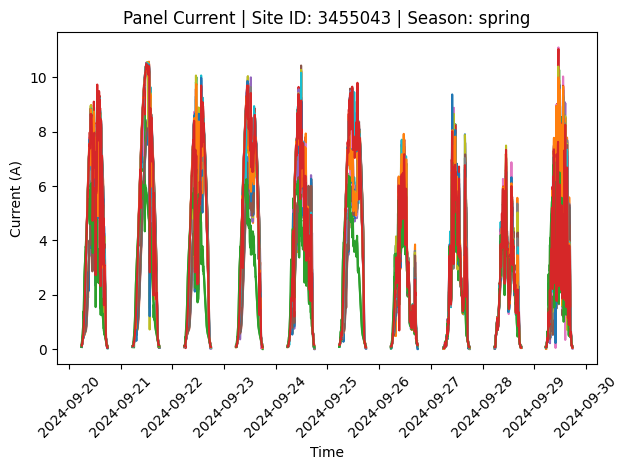

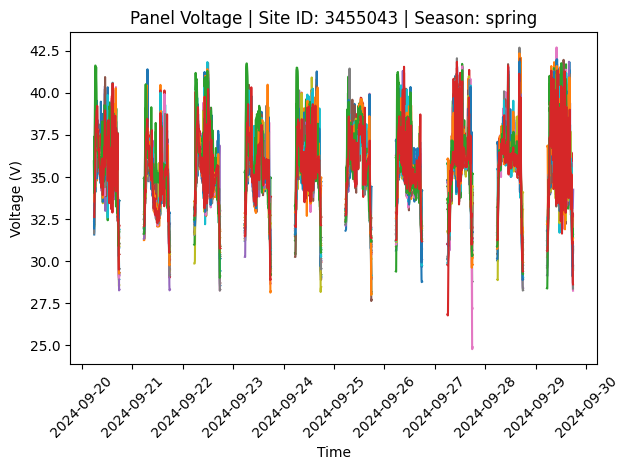

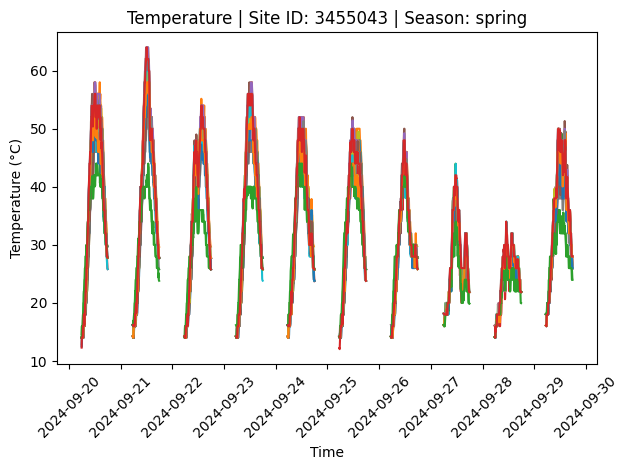

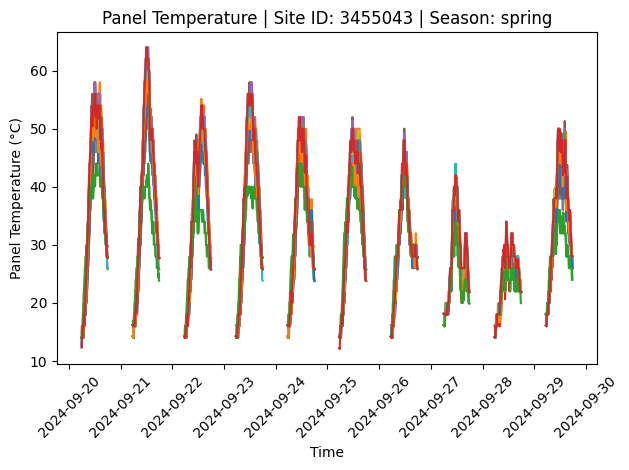

In [7]:
# Specify the number of days to plot
num_days_to_plot = 10

# Filter the data for the specified number of days
start_date = pd.to_datetime(merged_data['Timestamp'].iloc[0])
end_date = start_date + timedelta(days=num_days_to_plot)
filtered_data = merged_data[(pd.to_datetime(merged_data['Timestamp']) >= start_date) & 
                            (pd.to_datetime(merged_data['Timestamp']) < end_date)]

print(filtered_data)

# Plot Panel Current in an individual figure
plt.figure()
for reporter_id in reporter_ids:
    plt.plot(filtered_data['Timestamp'], filtered_data[f'panel_current_{reporter_id}'], label=f'Panel {reporter_id}')
plt.title(f'Panel Current | Site ID: {site_id} | Season: {season}')
plt.xlabel('Time')
plt.ylabel('Current (A)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot Panel Voltage in an individual figure
plt.figure()
for reporter_id in reporter_ids:
    plt.plot(filtered_data['Timestamp'], filtered_data[f'panel_voltage_{reporter_id}'], label=f'Panel {reporter_id}')
plt.title(f'Panel Voltage | Site ID: {site_id} | Season: {season}')
plt.xlabel('Time')
plt.ylabel('Voltage (V)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot Temperature in an individual figure
plt.figure()
for reporter_id in reporter_ids:
    plt.plot(filtered_data['Timestamp'], filtered_data[f'temperature_{reporter_id}'], label=f'Panel {reporter_id}')
plt.title(f'Temperature | Site ID: {site_id} | Season: {season}')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot Panel Temperature in an individual figure
plt.figure()
for reporter_id in reporter_ids:
    plt.plot(filtered_data['Timestamp'], filtered_data[f'panel_temperature_{reporter_id}'], label=f'Panel {reporter_id}')
plt.title(f'Panel Temperature | Site ID: {site_id} | Season: {season}')
plt.xlabel('Time')
plt.ylabel('Panel Temperature (°C)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 1.3. Module spec extraction

In [8]:
# find the .PAN file in the site_dir
pan_file = [f for f in os.listdir(site_dir) if f.endswith('.PAN')][0]

# read the .PAN file
pan_file_path = os.path.join(site_dir, pan_file)

with open(pan_file_path, 'r') as f:
    pan_data = f.readlines()
    # find the line that contains the "RSeries"
    for line in pan_data:
        if 'RSeries' in line:
            series_resistance = float(line.split('=')[1].strip())
            print(f"Series Resistance from PAN file: {series_resistance}")
    # find the line that contains the "RShunt"
    for line in pan_data:
        if 'RShunt' in line:
            shunt_resistance = float(line.split('=')[1].strip())
            print(f"Shunt Resistance from PAN file: {shunt_resistance}")
    # find the line that contains the "NCelS" as the number of cells in series
    for line in pan_data:
        if 'NCelS' in line:
            num_cells_series = int(line.split('=')[1].strip())
            print(f"Number of cells in series from PAN file: {num_cells_series}")
    # find the line that contains the "Gamma" as the ideality factor
    for line in pan_data:
        if 'Gamma' in line:
            ideality_factor = float(line.split('=')[1].strip())
            print(f"Ideality factor from PAN file: {ideality_factor}")
            break  # Exit the loop after finding the ideality factor

Series Resistance from PAN file: 0.13
Shunt Resistance from PAN file: 450.0
Number of cells in series from PAN file: 66
Ideality factor from PAN file: 1.045


# 2. Series connection power calculation

## 2.1. One diode model data extraction

The data of module they get it from PVsyst database, which is CS6K - 315MS from CSI Solar. Therefore I go to PVsyst, find the module and extract n, Ncell, Rs, Rsh, then put it below.

In [9]:
# Parameters for the one-diode model
# if site_id == '347166':
#     ideality_factor = 1.0081
#     num_cells_series = 60
#     thermal_voltage_25C = 0.0258
#     series_resistance = 0.302
#     shunt_resistance = 400
# elif site_id == '1398284':
#     ideality_factor = 0.954526056
#     num_cells_series = 120
#     thermal_voltage_25C = 0.0258
#     series_resistance = 0.229
#     shunt_resistance = 300

# # Constants for vth calculation
boltzmann_constant = const.Boltzmann  # Boltzmann constant in J/K
electron_charge = const.e  # Elementary charge in C

## 2.2. Calculate IV curves from MPPT

### 2.2.1. Include the power output (debugging)

In [10]:
# # Get the current timestamp when the code is run
# timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
# output_dir = os.path.join(base_dir, f'v_from_i/iv_curve_plots_{timestamp}_{season}_{site_id}')
# os.makedirs(output_dir, exist_ok=True)

# # List to keep track of file paths for the GIF
# image_files = []

# # DataFrames to store the sum of I*V and total power for each timestamp
# iv_sum_data = pd.DataFrame(columns=['Timestamp', 'Sum of I*V (W)'])
# total_power_data = pd.DataFrame(columns=['Timestamp', 'Total Power (W)'])

# # Determine fixed x and y axis limits for all plots
# y_limit = (0, 13)
# x_limit = (0, 50)  # Assuming a reasonable range for combined voltages

# # Generate a range of currents for plotting the IV curve
# currents = np.linspace(0, y_limit[1], 100)

# for idx in range(len(merged_data)):
#     plt.figure(figsize=(10, 6))
#     sum_iv = 0
#     total_power = 0

#     for optimiser in reporter_ids:
#         optimiser_voltage = merged_data[f'panel_voltage_{optimiser}']
#         optimiser_current = merged_data[f'panel_current_{optimiser}']
#         optimiser_power = merged_data[f'power_{optimiser}']

#         is_nan_or_zero = optimiser_voltage.iloc[idx] == 0 or optimiser_current.iloc[idx] == 0 or \
#                          np.isnan(optimiser_voltage.iloc[idx]) or np.isnan(optimiser_current.iloc[idx])

#         if not is_nan_or_zero:
#             panel_voltage = optimiser_voltage.iloc[idx]
#             panel_current = optimiser_current.iloc[idx]
#             panel_power = optimiser_power.iloc[idx]

#             # Add to sums
#             sum_iv += panel_voltage * panel_current
#             total_power += panel_power

#             # IV Curve Calculation
#             vth = boltzmann_constant * (merged_data[f'panel_temperature_{optimiser}'].iloc[idx] + 273.15) / electron_charge
#             params = {
#                 'photocurrent': panel_current,
#                 'saturation_current': I0(panel_current, panel_voltage, series_resistance, shunt_resistance, ideality_factor, num_cells_series, vth),
#                 'resistance_series': series_resistance,
#                 'resistance_shunt': shunt_resistance,
#                 'nNsVth': ideality_factor * num_cells_series * vth,
#             }
#             voltage_iv = pvlib.pvsystem.v_from_i(current=currents, **params)

#             # Plot IV curve
#             plt.plot(voltage_iv, currents, label=f'IV Curve - {optimiser}')

#             # Plot MPPT Point
#             plt.plot(panel_voltage, panel_current, 'ro', label=f'MPPT - {optimiser}')

#     # Store data for this timestamp
#     timestamp_title = pd.to_datetime(merged_data['Timestamp'].iloc[idx]).strftime('%Y-%m-%d %H:%M:%S')
#     iv_sum_data = pd.concat([iv_sum_data, pd.DataFrame({'Timestamp': [timestamp_title], 'Sum of I*V (W)': [sum_iv]})], ignore_index=True)
#     total_power_data = pd.concat([total_power_data, pd.DataFrame({'Timestamp': [timestamp_title], 'Total Power (W)': [total_power]})], ignore_index=True)

#     # Finalize plot
#     plt.xlabel('Voltage (V)')
#     plt.ylabel('Current (A)')
#     plt.title(f'IV Curves at {timestamp_title}\nSum of I*V: {sum_iv:.2f} W, Total Power: {total_power:.2f} W')
#     plt.grid(True)
#     plt.xlim(x_limit)
#     plt.ylim(y_limit)

#     # Save the plot
#     file_path = os.path.join(output_dir, f'iv_curve_{timestamp_title.replace(":", "-").replace(" ", "_")}.png')
#     plt.savefig(file_path)
#     plt.close()
#     image_files.append(file_path)



### 2.2.2. IV sum

In [11]:
# # Get the current timestamp when the code is run
# timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
# output_dir = os.path.join(base_dir, f'v_from_i/iv_curve_plots_{timestamp}_{season}_{site_id}')
# os.makedirs(output_dir, exist_ok=True)

# # List to keep track of file paths for the GIF
# image_files = []

# # DataFrame to store the sum of I*V for each timestamp
# iv_sum_data = pd.DataFrame(columns=['Timestamp', 'Sum of I*V (W)'])

# # Generate a range of currents for plotting the IV curve
# currents = np.linspace(0, y_limit_module[1], 100)

# # Loop through each time step
# for idx in range(len(merged_data)):

#     # Create a new figure for each time step
#     plt.figure(figsize=(10, 6))

#     # Initialize a counter for the number of IV curves in the plot
#     iv_curve_count = 0
#     sum_iv = 0  # Initialize sum of I*V

#     # Skip this time step if all optimizers have NaN or zero values
#     all_nan_or_zero = all(
#         merged_data[f'panel_voltage_{optimiser}'].iloc[idx] == 0 or
#         merged_data[f'panel_current_{optimiser}'].iloc[idx] == 0 or
#         np.isnan(merged_data[f'panel_voltage_{optimiser}'].iloc[idx]) or
#         np.isnan(merged_data[f'panel_current_{optimiser}'].iloc[idx])
#         for optimiser in reporter_ids
#     )
#     if all_nan_or_zero:
#         print(f"Time step {idx} has NaN or zero values for all optimizers.")
#         continue

#     # Loop through each optimiser
#     for optimiser in reporter_ids:
#         # Extract the IV data from the optimiser for the current time step
#         optimiser_voltage = merged_data[f'panel_voltage_{optimiser}']
#         optimiser_current = merged_data[f'panel_current_{optimiser}']
#         panel_temperature = merged_data[f'panel_temperature_{optimiser}']  # Panel temperature in °C

#         # Check if there are any NaN or zero values in the current and voltage
#         is_nan_or_zero = optimiser_voltage.iloc[idx] == 0 or optimiser_current.iloc[idx] == 0 or \
#                          np.isnan(optimiser_voltage.iloc[idx]) or np.isnan(optimiser_current.iloc[idx])

#         if is_nan_or_zero:
#             # If there are NaN or zero values, set voltage to zero for the entire current range
#             voltage = np.zeros_like(currents)
#             plt.plot(voltage, currents, label=f'Optimizer {optimiser}')
#             print(f"Time step {idx} has NaN or zero values for Optimizer {optimiser}.")
#         else:
#             # Convert panel temperature to Kelvin
#             panel_temperature_kelvin = panel_temperature.iloc[idx] + 273.15

#             # Calculate vth dynamically or use the fixed value
#             if use_dynamic_vth:
#                 vth = boltzmann_constant * panel_temperature_kelvin / electron_charge
#             else:
#                 vth = thermal_voltage_25C

#             # Extract voltage and current for the current time step
#             panel_voltage = optimiser_voltage.iloc[idx]
#             panel_current = optimiser_current.iloc[idx]

#             # Add I*V to the sum for this optimizer
#             sum_iv += panel_voltage * panel_current

#             # Calculate the I0 at the operating point for the current time step
#             I0_op = I0(panel_current, panel_voltage, series_resistance, shunt_resistance, ideality_factor, num_cells_series, vth)

#             # Calculate the IL at the operating point for the current time step
#             IL_op = IL(panel_current, panel_voltage, series_resistance, shunt_resistance, ideality_factor, num_cells_series, vth, I0_op)

#             # Use the single diode model to calculate voltage for each current point
#             params = {
#                 'photocurrent': IL_op,  # Photocurrent (light-generated current)
#                 'saturation_current': I0_op,  # Saturation current
#                 'resistance_series': series_resistance,  # Series resistance
#                 'resistance_shunt': shunt_resistance,  # Shunt resistance
#                 'nNsVth': ideality_factor * num_cells_series * vth  # Ideality factor * Cells in series * Thermal voltage
#             }

#             # Calculate voltage for each current point using the single diode model
#             voltage = pvlib.pvsystem.v_from_i(
#                 current=currents,
#                 photocurrent=params['photocurrent'],
#                 saturation_current=params['saturation_current'],
#                 resistance_series=params['resistance_series'],
#                 resistance_shunt=params['resistance_shunt'],
#                 nNsVth=params['nNsVth']
#             )

#             # Plot the IV curve for the current time step on the same axis
#             plt.plot(voltage, currents, label=f'Optimizer {optimiser}')

#             # Mark the panel voltage and panel current at this point
#             plt.plot(panel_voltage, panel_current, 'ro')  # Mark with a red circle

#         # Increment the counter for each plotted IV curve
#         iv_curve_count += 1

#     # Print out the number of IV curves in the plot
#     print(f"Time step {idx} has {iv_curve_count} IV curves plotted.")

#     # Store the sum of I*V in the DataFrame
#     timestamp_title = pd.to_datetime(merged_data['Timestamp'].iloc[idx]).strftime('%Y-%m-%d %H:%M:%S')
#     iv_sum_data = pd.concat([iv_sum_data, pd.DataFrame({'Timestamp': [timestamp_title], 'Sum of I*V (W)': [sum_iv]})], ignore_index=True)

#     # Set consistent x and y axis limits for all plots
#     plt.xlim(x_limit_module)
#     plt.ylim(y_limit_module)

#     # Finalize the plot for the current time step
#     plt.xlabel('Voltage (V)')
#     plt.ylabel('Current (A)')
#     plt.title(f'IV Curves at {timestamp_title}\nSum of I*V: {sum_iv:.2f} W')
#     plt.grid(True)

#     # Save the plot as a PNG file with "summer/winter" and site_id in the file name
#     file_path = os.path.join(output_dir, f'iv_curve_{timestamp_title.replace(":", "-").replace(" ", "_")}.png')
#     plt.savefig(file_path)
#     plt.close()

#     # Add the file path to the list for GIF creation
#     image_files.append(file_path)

# # Save the sum of I*V data to an Excel file
# excel_path = os.path.join(output_dir, 'iv_sum_data.xlsx')
# iv_sum_data.to_excel(excel_path, index=False)
# print(f"Excel file saved as: {excel_path}")

# # Create a GIF from the saved images with slower speed and loop indefinitely
# gif_path = os.path.join(output_dir, f'iv_curves_{season}_{site_id}.gif')
# with imageio.get_writer(gif_path, mode='I', duration=200, loop=0) as writer:
#     for filename in image_files:
#         image = imageio.imread(filename)
#         writer.append_data(image)

# print(f"GIF saved as '{gif_path}'")


### 2.2.3. With Raw data

In [12]:
# ============================
# Option to choose optimizers to run:
# If selected_optimizers is defined as a list (e.g. below), only those optimizers will be processed.
# If it is set to None, the code will run for all optimizers (i.e. all IDs in reporter_ids).
# ============================
selected_optimizers = ['241622244', '241622317', '241622327', '249776740']  
# To run for all optimizers, simply set:
# selected_optimizers = None

# Determine which optimizers to run:
if selected_optimizers is not None:
    optimizers_to_run = [opt for opt in reporter_ids if opt in selected_optimizers]
else:
    optimizers_to_run = reporter_ids

# Get the current timestamp when the code is run
import datetime
timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
output_dir = os.path.join(base_dir, f'v_from_i/iv_curve_plots_{timestamp}_{season}_{site_id}')
os.makedirs(output_dir, exist_ok=True)

# List to keep track of file paths for the GIF (for reconstructed IV plots)
import matplotlib.pyplot as plt
import imageio
import numpy as np
import pandas as pd
image_files = []

# DataFrame to store the sum of I*V for each timestamp
iv_sum_data = pd.DataFrame(columns=['Timestamp', 'Sum of I*V (W)'])

# Generate a range of currents for plotting the IV curve
currents = np.linspace(0, y_limit_module[1], 100)

# Loop through each time step
for idx in range(len(merged_data)):
    # Skip this time step if all optimizers have NaN or zero values
    all_nan_or_zero = all(
        merged_data[f'panel_voltage_{optimiser}'].iloc[idx] == 0 or
        merged_data[f'panel_current_{optimiser}'].iloc[idx] == 0 or
        np.isnan(merged_data[f'panel_voltage_{optimiser}'].iloc[idx]) or
        np.isnan(merged_data[f'panel_current_{optimiser}'].iloc[idx])
        for optimiser in reporter_ids
    )
    if all_nan_or_zero:
        print(f"Time step {idx} has NaN or zero values for all optimizers.")
        continue

    # ----- Reconstructed IV Plot -----
    plt.figure(figsize=(10, 6))
    iv_curve_count = 0
    sum_iv = 0  # Initialize sum of I*V

    # Loop through each optimizer in the selected list
    for optimiser in optimizers_to_run:
        optimiser_voltage = merged_data[f'panel_voltage_{optimiser}']
        optimiser_current = merged_data[f'panel_current_{optimiser}']
        panel_temperature = merged_data[f'panel_temperature_{optimiser}']  # in °C

        is_nan_or_zero = (
            optimiser_voltage.iloc[idx] == 0 or 
            optimiser_current.iloc[idx] == 0 or 
            np.isnan(optimiser_voltage.iloc[idx]) or 
            np.isnan(optimiser_current.iloc[idx])
        )

        if is_nan_or_zero:
            # If data is not valid, plot zeros for the current range
            voltage = np.zeros_like(currents)
            plt.plot(voltage, currents, label=f'Optimizer {optimiser}')
            print(f"Time step {idx} has NaN or zero values for Optimizer {optimiser}.")
        else:
            # Convert panel temperature to Kelvin
            panel_temperature_kelvin = panel_temperature.iloc[idx] + 273.15

            # Calculate vth dynamically or use fixed value
            if use_dynamic_vth:
                vth = boltzmann_constant * panel_temperature_kelvin / electron_charge
            else:
                vth = thermal_voltage_25C

            panel_voltage = optimiser_voltage.iloc[idx]
            panel_current = optimiser_current.iloc[idx]
            sum_iv += panel_voltage * panel_current

            # Calculate I0 and IL at the operating point
            I0_op = I0(panel_current, panel_voltage, series_resistance, shunt_resistance, ideality_factor, num_cells_series, vth)
            IL_op = IL(panel_current, panel_voltage, series_resistance, shunt_resistance, ideality_factor, num_cells_series, vth, I0_op)

            params = {
                'photocurrent': IL_op,
                'saturation_current': I0_op,
                'resistance_series': series_resistance,
                'resistance_shunt': shunt_resistance,
                'nNsVth': ideality_factor * num_cells_series * vth
            }

            # Compute reconstructed voltage curve
            voltage = pvlib.pvsystem.v_from_i(
                current=currents,
                photocurrent=params['photocurrent'],
                saturation_current=params['saturation_current'],
                resistance_series=params['resistance_series'],
                resistance_shunt=params['resistance_shunt'],
                nNsVth=params['nNsVth']
            )

            # Plot reconstructed IV curve
            plt.plot(voltage, currents, label=f'Optimizer {optimiser}')
            # Mark the measured operating point (MPPT)
            plt.plot(panel_voltage, panel_current, 'ro')

        iv_curve_count += 1

    timestamp_title = pd.to_datetime(merged_data['Timestamp'].iloc[idx]).strftime('%Y-%m-%d %H:%M:%S')
    iv_sum_data = pd.concat([iv_sum_data, pd.DataFrame({'Timestamp': [timestamp_title], 'Sum of I*V (W)': [sum_iv]})], ignore_index=True)

    plt.xlim(x_limit_module)
    plt.ylim(y_limit_module)
    plt.xlabel('Voltage (V)')
    plt.ylabel('Current (A)')
    # Updated title with site ID
    plt.title(f'IV Curves at {timestamp_title} for Site {site_id}\nSum of I*V: {sum_iv:.2f} W')
    plt.grid(True)
    
    # Place the legend outside the plot with 4 columns
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=4)

    # Save the reconstructed IV plot
    file_path = os.path.join(output_dir, f'iv_curve_{timestamp_title.replace(":", "-").replace(" ", "_")}.png')
    plt.savefig(file_path, bbox_inches='tight')
    plt.close()
    image_files.append(file_path)
    print(f"Reconstructed IV plot saved: {file_path}")

    # ----- Raw Data Plot -----
    # Create a new figure for raw measured data
    plt.figure(figsize=(10, 6))
    
    # Loop through each optimizer in the selected list and plot the raw measurement (single point)
    for optimiser in optimizers_to_run:
        optimiser_voltage = merged_data[f'panel_voltage_{optimiser}']
        optimiser_current = merged_data[f'panel_current_{optimiser}']
        # Check if valid data exists
        is_nan_or_zero = (
            optimiser_voltage.iloc[idx] == 0 or 
            optimiser_current.iloc[idx] == 0 or 
            np.isnan(optimiser_voltage.iloc[idx]) or 
            np.isnan(optimiser_current.iloc[idx])
        )
        if not is_nan_or_zero:
            panel_voltage = optimiser_voltage.iloc[idx]
            panel_current = optimiser_current.iloc[idx]
            plt.plot(panel_voltage, panel_current, 'ro', markersize=8, label=f'Optimizer {optimiser}')
        else:
            # Optionally, mark missing data differently
            plt.plot(0, 0, 'kx', label=f'Optimizer {optimiser} (no data)')

    plt.xlim(x_limit_module)
    plt.ylim(y_limit_module)
    plt.xlabel('Voltage (V)')
    plt.ylabel('Current (A)')
    # Updated title with site ID
    plt.title(f'Raw IV Data at {timestamp_title} for Site {site_id}')
    plt.grid(True)
    # Save the raw data plot with a modified filename
    raw_file_path = os.path.join(output_dir, f'iv_curve_raw_{timestamp_title.replace(":", "-").replace(" ", "_")}.png')
    plt.savefig(raw_file_path, bbox_inches='tight')
    plt.close()
    print(f"Raw IV plot saved: {raw_file_path}")

# Save the sum of I*V data to an Excel file
excel_path = os.path.join(output_dir, 'iv_sum_data.xlsx')
iv_sum_data.to_excel(excel_path, index=False)
print(f"Excel file saved as: {excel_path}")

# Create a GIF from the reconstructed IV images with slower speed and loop indefinitely
gif_path = os.path.join(output_dir, f'iv_curves_{season}_{site_id}.gif')
with imageio.get_writer(gif_path, mode='I', duration=200, loop=0) as writer:
    for filename in image_files:
        image = imageio.imread(filename)
        writer.append_data(image)

print(f"GIF saved as '{gif_path}'")


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_05-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_05-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_05-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_05-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_05-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_05-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_06-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_06-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_06-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_06-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_06-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_06-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_06-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_06-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_06-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_06-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_06-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_06-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_06-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_06-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_06-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_06-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_06-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_06-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_06-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_06-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_06-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_06-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_06-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_06-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_07-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_07-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_07-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_07-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_07-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_07-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_07-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_07-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_07-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_07-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_07-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_07-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_07-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_07-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_07-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_07-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_07-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_07-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_07-45-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_07-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_07-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_07-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_07-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_07-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_08-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_08-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_08-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_08-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_08-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_08-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_08-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_08-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_08-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_08-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_08-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_08-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_08-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_08-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_08-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_08-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_08-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_08-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_08-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_08-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_08-50-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_08-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_08-55-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_08-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_09-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_09-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_09-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_09-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_09-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_09-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_09-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_09-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_09-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_09-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_09-25-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_09-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_09-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_09-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_09-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_09-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_09-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_09-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_09-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_09-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_09-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_09-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_09-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_09-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_10-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_10-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_10-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_10-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_10-10-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_10-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_10-15-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_10-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_10-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_10-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_10-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_10-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_10-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_10-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_10-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_10-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_10-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_10-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_10-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_10-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_10-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_10-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_10-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_10-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_11-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_11-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_11-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_11-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_11-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_11-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_11-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_11-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_11-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_11-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_11-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_11-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_11-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_11-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_11-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_11-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_11-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_11-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_11-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_11-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_11-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_11-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_11-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_11-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_12-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_12-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_12-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_12-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_12-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_12-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_12-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_12-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_12-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_12-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_12-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_12-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_12-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_12-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_12-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_12-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_12-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_12-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_12-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_12-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_12-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_12-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_12-55-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_12-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_13-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_13-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_13-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_13-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_13-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_13-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_13-15-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_13-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_13-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_13-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_13-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_13-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_13-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_13-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_13-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_13-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_13-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_13-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_13-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_13-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_13-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_13-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_13-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_13-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_14-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_14-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_14-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_14-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_14-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_14-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_14-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_14-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_14-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_14-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_14-25-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_14-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_14-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_14-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_14-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_14-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_14-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_14-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_14-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_14-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_14-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_14-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_14-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_14-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_15-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_15-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_15-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_15-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_15-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_15-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_15-15-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_15-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_15-20-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_15-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_15-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_15-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_15-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_15-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_15-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_15-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_15-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_15-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_15-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_15-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_15-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_15-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_15-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_15-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_16-00-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_16-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_16-05-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_16-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_16-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_16-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_16-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_16-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_16-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_16-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_16-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_16-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_16-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_16-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_16-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_16-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_16-40-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_16-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_16-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_16-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_16-50-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_16-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_16-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_16-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_17-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_17-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_17-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_17-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_17-10-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_17-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_17-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_17-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_17-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_17-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_17-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_17-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_17-30-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_17-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_17-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_17-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_17-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_17-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_17-45-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_17-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_17-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_17-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-20_17-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-20_17-55-00.png
Time step 147 has NaN or zero values for all optimizers.
Time step 148 has NaN or zero values for all optimizers.
Time step 149 has NaN or zero values for all optimizers.
Time step 150 has NaN or zero values for all optimizers.
Time step 151 has NaN or zero values for all optimizers.
Time step 152 has NaN or zero values for all optimizers.
Time step 153 has NaN or zero values for all optimizers.
Time step 154 has NaN or zero values for all optimizers.
Time step 155 has NaN or zero values for all optimizers.
Time step 156 has NaN or zero values for all optimizers.
Time step 157 has NaN or zero values for all optimizers.
Time step 158 has NaN or zero values for all optimizers.
Time step 159 has NaN or zero values for all optimizers.
Time step 160 has NaN or zero values for all optimizers.
Time step 161 has NaN or zer

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_05-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_05-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_05-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_05-40-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_05-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_05-45-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_05-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_05-50-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_05-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_05-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_05-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_06-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_06-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_06-05-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_06-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_06-10-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_06-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_06-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_06-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_06-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_06-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_06-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_06-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_06-30-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_06-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_06-35-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_06-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_06-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_06-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_06-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_06-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_06-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_06-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_06-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_06-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_07-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_07-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_07-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_07-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_07-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_07-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_07-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_07-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_07-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_07-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_07-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_07-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_07-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_07-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_07-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_07-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_07-40-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_07-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_07-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_07-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_07-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_07-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_07-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_07-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_08-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_08-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_08-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_08-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_08-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_08-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_08-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_08-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_08-20-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_08-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_08-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_08-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_08-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_08-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_08-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_08-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_08-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_08-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_08-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_08-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_08-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_08-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_08-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_08-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_09-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_09-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_09-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_09-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_09-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_09-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_09-15-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_09-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_09-20-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_09-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_09-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_09-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_09-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_09-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_09-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_09-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_09-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_09-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_09-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_09-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_09-50-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_09-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_09-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_09-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_10-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_10-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_10-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_10-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_10-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_10-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_10-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_10-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_10-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_10-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_10-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_10-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_10-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_10-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_10-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_10-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_10-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_10-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_10-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_10-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_10-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_10-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_10-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_10-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_11-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_11-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_11-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_11-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_11-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_11-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_11-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_11-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_11-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_11-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_11-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_11-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_11-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_11-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_11-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_11-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_11-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_11-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_11-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_11-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_11-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_11-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_11-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_11-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_12-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_12-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_12-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_12-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_12-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_12-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_12-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_12-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_12-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_12-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_12-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_12-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_12-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_12-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_12-35-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_12-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_12-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_12-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_12-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_12-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_12-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_12-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_12-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_12-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_13-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_13-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_13-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_13-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_13-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_13-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_13-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_13-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_13-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_13-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_13-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_13-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_13-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_13-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_13-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_13-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_13-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_13-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_13-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_13-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_13-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_13-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_13-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_13-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_14-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_14-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_14-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_14-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_14-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_14-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_14-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_14-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_14-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_14-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_14-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_14-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_14-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_14-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_14-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_14-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_14-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_14-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_14-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_14-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_14-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_14-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_14-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_14-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_15-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_15-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_15-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_15-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_15-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_15-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_15-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_15-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_15-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_15-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_15-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_15-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_15-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_15-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_15-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_15-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_15-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_15-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_15-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_15-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_15-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_15-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_15-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_15-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_16-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_16-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_16-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_16-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_16-10-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_16-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_16-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_16-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_16-20-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_16-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_16-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_16-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_16-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_16-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_16-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_16-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_16-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_16-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_16-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_16-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_16-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_16-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_16-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_16-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_17-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_17-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_17-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_17-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_17-10-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_17-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_17-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_17-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_17-20-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_17-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_17-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_17-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_17-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_17-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_17-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_17-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_17-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_17-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_17-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_17-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_17-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_17-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-21_17-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-21_17-55-00.png
Time step 435 has NaN or zero values for all optimizers.
Time step 436 has NaN or zero values for all optimizers.
Time step 437 has NaN or zero values for all optimizers.
Time step 438 has NaN or zero values for all optimizers.
Time step 439 has NaN or zero values for all optimizers.
Time step 440 has NaN or zero values for all optimizers.
Time step 441 has NaN or zero values for all optimizers.
Time step 442 has NaN or zero values for all optimizers.
Time step 443 has NaN or zero values for all optimizers.
Time step 444 has NaN or zero values for all optimizers.
Time step 445 has NaN or zero values for all optimizers.
Time step 446 has NaN or zero values for all optimizers.
Time step 447 has NaN or zero values for all optimizers.
Time step 448 has NaN or zero values for all optimizers.
Time step 449 has NaN or zer

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_05-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_05-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_05-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_05-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_05-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_05-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_05-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_05-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_05-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_05-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_05-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_06-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_06-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_06-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_06-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_06-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_06-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_06-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_06-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_06-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_06-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_06-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_06-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_06-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_06-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_06-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_06-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_06-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_06-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_06-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_06-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_06-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_06-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_06-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_06-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_07-00-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_07-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_07-05-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_07-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_07-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_07-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_07-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_07-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_07-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_07-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_07-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_07-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_07-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_07-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_07-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_07-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_07-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_07-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_07-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_07-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_07-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_07-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_07-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_07-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_08-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_08-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_08-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_08-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_08-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_08-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_08-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_08-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_08-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_08-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_08-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_08-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_08-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_08-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_08-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_08-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_08-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_08-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_08-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_08-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_08-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_08-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_08-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_08-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_09-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_09-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_09-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_09-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_09-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_09-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_09-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_09-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_09-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_09-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_09-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_09-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_09-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_09-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_09-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_09-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_09-40-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_09-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_09-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_09-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_09-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_09-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_09-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_09-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_10-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_10-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_10-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_10-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_10-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_10-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_10-15-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_10-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_10-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_10-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_10-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_10-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_10-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_10-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_10-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_10-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_10-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_10-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_10-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_10-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_10-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_10-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_10-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_10-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_11-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_11-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_11-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_11-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_11-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_11-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_11-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_11-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_11-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_11-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_11-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_11-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_11-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_11-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_11-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_11-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_11-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_11-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_11-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_11-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_11-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_11-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_11-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_11-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_12-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_12-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_12-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_12-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_12-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_12-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_12-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_12-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_12-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_12-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_12-25-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_12-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_12-30-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_12-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_12-35-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_12-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_12-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_12-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_12-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_12-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_12-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_12-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_12-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_12-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_13-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_13-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_13-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_13-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_13-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_13-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_13-15-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_13-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_13-20-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_13-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_13-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_13-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_13-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_13-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_13-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_13-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_13-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_13-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_13-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_13-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_13-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_13-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_13-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_13-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_14-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_14-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_14-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_14-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_14-10-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_14-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_14-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_14-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_14-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_14-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_14-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_14-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_14-30-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_14-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_14-35-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_14-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_14-40-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_14-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_14-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_14-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_14-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_14-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_14-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_14-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_15-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_15-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_15-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_15-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_15-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_15-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_15-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_15-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_15-20-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_15-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_15-25-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_15-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_15-30-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_15-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_15-35-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_15-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_15-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_15-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_15-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_15-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_15-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_15-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_15-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_15-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_16-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_16-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_16-05-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_16-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_16-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_16-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_16-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_16-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_16-20-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_16-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_16-25-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_16-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_16-30-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_16-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_16-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_16-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_16-40-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_16-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_16-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_16-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_16-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_16-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_16-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_16-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_17-00-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_17-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_17-05-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_17-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_17-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_17-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_17-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_17-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_17-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_17-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_17-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_17-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_17-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_17-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_17-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_17-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_17-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_17-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_17-45-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_17-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_17-50-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_17-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-22_17-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-22_17-55-00.png
Time step 723 has NaN or zero values for all optimizers.
Time step 724 has NaN or zero values for all optimizers.
Time step 725 has NaN or zero values for all optimizers.
Time step 726 has NaN or zero values for all optimizers.
Time step 727 has NaN or zero values for all optimizers.
Time step 728 has NaN or zero values for all optimizers.
Time step 729 has NaN or zero values for all optimizers.
Time step 730 has NaN or zero values for all optimizers.
Time step 731 has NaN or zero values for all optimizers.
Time step 732 has NaN or zero values for all optimizers.
Time step 733 has NaN or zero values for all optimizers.
Time step 734 has NaN or zero values for all optimizers.
Time step 735 has NaN or zero values for all optimizers.
Time step 736 has NaN or zero values for all optimizers.
Time step 737 has NaN or zer

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_05-35-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_05-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_05-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_05-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_05-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_05-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_05-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_05-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_05-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_05-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_06-00-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_06-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_06-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_06-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_06-10-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_06-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_06-15-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_06-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_06-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_06-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_06-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_06-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_06-30-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_06-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_06-35-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_06-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_06-40-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_06-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_06-45-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_06-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_06-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_06-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_06-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_06-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_07-00-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_07-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_07-05-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_07-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_07-10-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_07-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_07-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_07-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_07-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_07-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_07-25-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_07-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_07-30-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_07-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_07-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_07-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_07-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_07-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_07-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_07-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_07-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_07-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_07-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_07-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_08-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_08-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_08-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_08-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_08-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_08-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_08-15-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_08-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_08-20-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_08-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_08-25-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_08-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_08-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_08-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_08-35-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_08-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_08-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_08-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_08-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_08-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_08-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_08-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_08-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_08-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_09-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_09-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_09-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_09-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_09-10-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_09-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_09-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_09-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_09-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_09-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_09-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_09-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_09-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_09-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_09-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_09-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_09-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_09-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_09-45-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_09-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_09-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_09-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_09-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_09-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_10-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_10-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_10-05-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_10-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_10-10-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_10-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_10-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_10-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_10-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_10-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_10-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_10-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_10-30-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_10-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_10-35-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_10-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_10-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_10-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_10-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_10-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_10-50-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_10-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_10-55-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_10-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_11-00-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_11-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_11-05-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_11-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_11-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_11-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_11-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_11-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_11-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_11-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_11-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_11-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_11-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_11-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_11-35-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_11-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_11-40-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_11-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_11-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_11-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_11-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_11-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_11-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_11-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_12-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_12-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_12-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_12-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_12-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_12-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_12-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_12-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_12-20-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_12-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_12-25-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_12-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_12-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_12-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_12-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_12-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_12-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_12-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_12-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_12-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_12-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_12-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_12-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_12-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_13-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_13-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_13-05-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_13-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_13-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_13-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_13-15-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_13-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_13-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_13-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_13-25-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_13-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_13-30-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_13-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_13-35-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_13-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_13-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_13-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_13-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_13-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_13-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_13-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_13-55-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_13-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_14-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_14-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_14-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_14-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_14-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_14-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_14-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_14-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_14-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_14-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_14-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_14-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_14-30-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_14-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_14-35-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_14-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_14-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_14-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_14-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_14-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_14-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_14-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_14-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_14-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_15-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_15-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_15-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_15-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_15-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_15-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_15-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_15-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_15-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_15-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_15-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_15-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_15-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_15-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_15-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_15-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_15-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_15-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_15-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_15-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_15-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_15-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_15-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_15-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_16-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_16-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_16-05-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_16-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_16-10-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_16-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_16-15-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_16-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_16-20-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_16-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_16-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_16-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_16-30-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_16-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_16-35-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_16-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_16-40-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_16-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_16-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_16-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_16-50-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_16-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_16-55-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_16-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_17-00-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_17-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_17-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_17-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_17-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_17-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_17-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_17-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_17-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_17-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_17-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_17-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_17-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_17-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_17-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_17-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_17-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_17-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_17-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_17-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_17-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_17-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-23_17-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-23_17-55-00.png
Time step 1011 has NaN or zero values for all optimizers.
Time step 1012 has NaN or zero values for all optimizers.
Time step 1013 has NaN or zero values for all optimizers.
Time step 1014 has NaN or zero values for all optimizers.
Time step 1015 has NaN or zero values for all optimizers.
Time step 1016 has NaN or zero values for all optimizers.
Time step 1017 has NaN or zero values for all optimizers.
Time step 1018 has NaN or zero values for all optimizers.
Time step 1019 has NaN or zero values for all optimizers.
Time step 1020 has NaN or zero values for all optimizers.
Time step 1021 has NaN or zero values for all optimizers.
Time step 1022 has NaN or zero values for all optimizers.
Time step 1023 has NaN or zero values for all optimizers.
Time step 1024 has NaN or zero values for all optimizers.
Time step 1025

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_05-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_05-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_05-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_05-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_05-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_05-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_05-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_05-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_05-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_05-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_05-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_05-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_05-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_06-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_06-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_06-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_06-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_06-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_06-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_06-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_06-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_06-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_06-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_06-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_06-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_06-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_06-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_06-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_06-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_06-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_06-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_06-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_06-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_06-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_06-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_06-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_06-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_07-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_07-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_07-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_07-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_07-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_07-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_07-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_07-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_07-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_07-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_07-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_07-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_07-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_07-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_07-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_07-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_07-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_07-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_07-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_07-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_07-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_07-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_07-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_07-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_08-00-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_08-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_08-05-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_08-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_08-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_08-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_08-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_08-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_08-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_08-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_08-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_08-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_08-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_08-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_08-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_08-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_08-40-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_08-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_08-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_08-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_08-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_08-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_08-55-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_08-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_09-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_09-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_09-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_09-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_09-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_09-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_09-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_09-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_09-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_09-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_09-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_09-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_09-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_09-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_09-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_09-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_09-40-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_09-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_09-45-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_09-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_09-50-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_09-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_09-55-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_09-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_10-00-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_10-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_10-05-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_10-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_10-10-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_10-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_10-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_10-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_10-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_10-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_10-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_10-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_10-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_10-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_10-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_10-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_10-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_10-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_10-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_10-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_10-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_10-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_10-55-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_10-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_11-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_11-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_11-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_11-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_11-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_11-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_11-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_11-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_11-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_11-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_11-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_11-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_11-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_11-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_11-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_11-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_11-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_11-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_11-45-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_11-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_11-50-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_11-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_11-55-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_11-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_12-00-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_12-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_12-05-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_12-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_12-10-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_12-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_12-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_12-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_12-20-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_12-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_12-25-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_12-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_12-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_12-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_12-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_12-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_12-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_12-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_12-45-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_12-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_12-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_12-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_12-55-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_12-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_13-00-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_13-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_13-05-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_13-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_13-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_13-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_13-15-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_13-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_13-20-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_13-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_13-25-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_13-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_13-30-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_13-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_13-35-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_13-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_13-40-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_13-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_13-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_13-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_13-50-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_13-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_13-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_13-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_14-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_14-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_14-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_14-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_14-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_14-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_14-15-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_14-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_14-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_14-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_14-25-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_14-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_14-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_14-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_14-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_14-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_14-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_14-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_14-45-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_14-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_14-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_14-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_14-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_14-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_15-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_15-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_15-05-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_15-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_15-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_15-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_15-15-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_15-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_15-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_15-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_15-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_15-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_15-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_15-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_15-35-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_15-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_15-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_15-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_15-45-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_15-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_15-50-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_15-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_15-55-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_15-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_16-00-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_16-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_16-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_16-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_16-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_16-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_16-15-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_16-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_16-20-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_16-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_16-25-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_16-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_16-30-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_16-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_16-35-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_16-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_16-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_16-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_16-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_16-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_16-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_16-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_16-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_16-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_17-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_17-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_17-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_17-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_17-10-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_17-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_17-15-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_17-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_17-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_17-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_17-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_17-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_17-30-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_17-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_17-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_17-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_17-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_17-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_17-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_17-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_17-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_17-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_17-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_17-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-24_18-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-24_18-00-00.png
Time step 1300 has NaN or zero values for all optimizers.
Time step 1301 has NaN or zero values for all optimizers.
Time step 1302 has NaN or zero values for all optimizers.
Time step 1303 has NaN or zero values for all optimizers.
Time step 1304 has NaN or zero values for all optimizers.
Time step 1305 has NaN or zero values for all optimizers.
Time step 1306 has NaN or zero values for all optimizers.
Time step 1307 has NaN or zero values for all optimizers.
Time step 1308 has NaN or zero values for all optimizers.
Time step 1309 has NaN or zero values for all optimizers.
Time step 1310 has NaN or zero values for all optimizers.
Time step 1311 has NaN or zero values for all optimizers.
Time step 1312 has NaN or zero values for all optimizers.
Time step 1313 has NaN or zero values for all optimizers.
Time step 1314

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_05-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_05-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_05-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_05-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_05-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_05-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_05-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_05-45-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_05-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_05-50-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_05-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_05-55-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_05-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_06-00-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_06-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_06-05-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_06-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_06-10-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_06-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_06-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_06-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_06-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_06-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_06-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_06-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_06-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_06-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_06-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_06-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_06-40-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_06-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_06-45-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_06-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_06-50-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_06-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_06-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_06-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_07-00-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_07-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_07-05-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_07-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_07-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_07-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_07-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_07-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_07-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_07-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_07-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_07-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_07-30-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_07-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_07-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_07-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_07-40-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_07-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_07-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_07-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_07-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_07-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_07-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_07-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_08-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_08-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_08-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_08-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_08-10-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_08-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_08-15-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_08-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_08-20-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_08-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_08-25-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_08-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_08-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_08-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_08-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_08-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_08-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_08-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_08-45-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_08-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_08-50-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_08-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_08-55-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_08-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_09-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_09-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_09-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_09-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_09-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_09-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_09-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_09-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_09-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_09-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_09-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_09-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_09-30-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_09-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_09-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_09-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_09-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_09-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_09-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_09-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_09-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_09-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_09-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_09-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_10-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_10-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_10-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_10-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_10-10-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_10-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_10-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_10-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_10-20-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_10-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_10-25-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_10-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_10-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_10-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_10-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_10-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_10-40-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_10-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_10-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_10-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_10-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_10-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_10-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_10-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_11-00-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_11-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_11-05-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_11-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_11-10-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_11-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_11-15-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_11-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_11-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_11-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_11-25-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_11-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_11-30-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_11-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_11-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_11-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_11-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_11-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_11-45-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_11-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_11-50-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_11-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_11-55-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_11-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_12-00-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_12-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_12-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_12-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_12-10-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_12-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_12-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_12-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_12-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_12-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_12-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_12-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_12-30-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_12-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_12-35-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_12-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_12-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_12-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_12-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_12-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_12-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_12-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_12-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_12-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_13-00-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_13-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_13-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_13-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_13-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_13-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_13-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_13-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_13-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_13-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_13-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_13-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_13-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_13-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_13-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_13-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_13-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_13-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_13-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_13-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_13-50-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_13-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_13-55-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_13-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_14-00-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_14-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_14-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_14-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_14-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_14-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_14-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_14-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_14-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_14-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_14-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_14-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_14-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_14-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_14-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_14-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_14-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_14-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_14-45-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_14-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_14-50-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_14-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_14-55-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_14-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_15-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_15-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_15-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_15-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_15-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_15-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_15-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_15-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_15-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_15-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_15-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_15-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_15-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_15-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_15-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_15-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_15-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_15-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_15-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_15-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_15-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_15-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_15-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_15-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_16-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_16-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_16-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_16-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_16-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_16-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_16-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_16-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_16-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_16-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_16-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_16-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_16-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_16-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_16-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_16-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_16-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_16-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_16-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_16-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_16-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_16-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_16-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_16-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_17-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_17-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_17-05-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_17-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_17-10-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_17-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_17-15-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_17-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_17-20-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_17-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_17-25-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_17-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_17-30-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_17-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_17-35-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_17-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_17-40-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_17-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_17-45-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_17-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_17-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_17-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-25_17-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-25_17-55-00.png
Time step 1587 has NaN or zero values for all optimizers.
Time step 1588 has NaN or zero values for all optimizers.
Time step 1589 has NaN or zero values for all optimizers.
Time step 1590 has NaN or zero values for all optimizers.
Time step 1591 has NaN or zero values for all optimizers.
Time step 1592 has NaN or zero values for all optimizers.
Time step 1593 has NaN or zero values for all optimizers.
Time step 1594 has NaN or zero values for all optimizers.
Time step 1595 has NaN or zero values for all optimizers.
Time step 1596 has NaN or zero values for all optimizers.
Time step 1597 has NaN or zero values for all optimizers.
Time step 1598 has NaN or zero values for all optimizers.
Time step 1599 has NaN or zero values for all optimizers.
Time step 1600 has NaN or zero values for all optimizers.
Time step 1601

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_05-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_05-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_05-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_05-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_05-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_05-40-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_05-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_05-45-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_05-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_05-50-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_05-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_05-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_05-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_06-00-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_06-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_06-05-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_06-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_06-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_06-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_06-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_06-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_06-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_06-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_06-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_06-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_06-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_06-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_06-35-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_06-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_06-40-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_06-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_06-45-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_06-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_06-50-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_06-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_06-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_06-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_07-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_07-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_07-05-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_07-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_07-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_07-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_07-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_07-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_07-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_07-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_07-25-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_07-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_07-30-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_07-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_07-35-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_07-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_07-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_07-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_07-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_07-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_07-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_07-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_07-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_07-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_08-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_08-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_08-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_08-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_08-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_08-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_08-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_08-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_08-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_08-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_08-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_08-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_08-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_08-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_08-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_08-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_08-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_08-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_08-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_08-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_08-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_08-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_08-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_08-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_09-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_09-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_09-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_09-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_09-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_09-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_09-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_09-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_09-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_09-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_09-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_09-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_09-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_09-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_09-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_09-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_09-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_09-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_09-45-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_09-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_09-50-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_09-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_09-55-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_09-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_10-00-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_10-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_10-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_10-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_10-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_10-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_10-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_10-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_10-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_10-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_10-25-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_10-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_10-30-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_10-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_10-35-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_10-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_10-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_10-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_10-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_10-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_10-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_10-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_10-55-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_10-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_11-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_11-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_11-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_11-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_11-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_11-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_11-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_11-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_11-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_11-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_11-25-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_11-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_11-30-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_11-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_11-35-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_11-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_11-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_11-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_11-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_11-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_11-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_11-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_11-55-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_11-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_12-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_12-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_12-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_12-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_12-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_12-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_12-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_12-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_12-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_12-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_12-25-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_12-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_12-30-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_12-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_12-35-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_12-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_12-40-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_12-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_12-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_12-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_12-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_12-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_12-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_12-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_13-00-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_13-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_13-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_13-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_13-10-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_13-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_13-15-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_13-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_13-20-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_13-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_13-25-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_13-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_13-30-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_13-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_13-35-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_13-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_13-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_13-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_13-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_13-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_13-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_13-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_13-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_13-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_14-00-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_14-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_14-05-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_14-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_14-10-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_14-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_14-15-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_14-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_14-20-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_14-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_14-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_14-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_14-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_14-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_14-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_14-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_14-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_14-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_14-45-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_14-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_14-50-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_14-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_14-55-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_14-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_15-00-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_15-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_15-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_15-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_15-10-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_15-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_15-15-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_15-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_15-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_15-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_15-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_15-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_15-30-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_15-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_15-35-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_15-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_15-40-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_15-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_15-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_15-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_15-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_15-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_15-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_15-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_16-00-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_16-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_16-05-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_16-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_16-10-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_16-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_16-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_16-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_16-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_16-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_16-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_16-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_16-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_16-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_16-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_16-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_16-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_16-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_16-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_16-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_16-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_16-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_16-55-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_16-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_17-00-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_17-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_17-05-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_17-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_17-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_17-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_17-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_17-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_17-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_17-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_17-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_17-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_17-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_17-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_17-35-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_17-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_17-40-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_17-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_17-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_17-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_17-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_17-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-26_17-55-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-26_17-55-00.png
Time step 1875 has NaN or zero values for all optimizers.
Time step 1876 has NaN or zero values for all optimizers.
Time step 1877 has NaN or zero values for all optimizers.
Time step 1878 has NaN or zero values for all optimizers.
Time step 1879 has NaN or zero values for all optimizers.
Time step 1880 has NaN or zero values for all optimizers.
Time step 1881 has NaN or zero values for all optimizers.
Time step 1882 has NaN or zero values for all optimizers.
Time ste

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Time step 1900 has NaN or zero values for all optimizers.
Time step 1901 has NaN or zero values for all optimizers.
Time step 1902 has NaN or zero values for all optimizers.
Time step 1903 has NaN or zero values for all optimizers.
Time step 1904 has NaN or zero values for all optimizers.
Time step 1905 has NaN or zero values for all optimizers.
Time step 1906 has NaN or zero values for all optimizers.
Time step 1907 has NaN or zero values for all optimizers.
Time step 1908 has NaN or zero values for all optimizers.
Time step 1909 has NaN or zero values for all optimizers.
Time step 1910 has NaN or zero values for all optimizers.
Time step 1911 has NaN or zero values for all optimizers.
Time step 1912 has NaN or zero values for all optimizers.
Time step 1913 has NaN or zero values for all optimizers.
Time step 1914 has NaN or zero values for all optimizers.
Time step 1915 has NaN or zero values for all optimizers.
Time step 1916 has NaN or zero values for all optimizers.
Time step 1917

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_05-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_06-00-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_06-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_06-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_06-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_06-10-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_06-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_06-15-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_06-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_06-20-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_06-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_06-25-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_06-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_06-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_06-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_06-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_06-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_06-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_06-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_06-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_06-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_06-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_06-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_06-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_06-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_07-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_07-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_07-05-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_07-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_07-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_07-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_07-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_07-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_07-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_07-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_07-25-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_07-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_07-30-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_07-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_07-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_07-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_07-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_07-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_07-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_07-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_07-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_07-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_07-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_07-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_08-00-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_08-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_08-05-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_08-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_08-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_08-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_08-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_08-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_08-20-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_08-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_08-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_08-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_08-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_08-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_08-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_08-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_08-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_08-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_08-45-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_08-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_08-50-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_08-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_08-55-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_08-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_09-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_09-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_09-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_09-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_09-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_09-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_09-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_09-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_09-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_09-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_09-25-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_09-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_09-30-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_09-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_09-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_09-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_09-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_09-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_09-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_09-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_09-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_09-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_09-55-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_09-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_10-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_10-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_10-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_10-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_10-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_10-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_10-15-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_10-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_10-20-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_10-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_10-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_10-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_10-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_10-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_10-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_10-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_10-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_10-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_10-45-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_10-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_10-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_10-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_10-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_10-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_11-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_11-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_11-05-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_11-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_11-10-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_11-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_11-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_11-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_11-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_11-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_11-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_11-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_11-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_11-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_11-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_11-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_11-40-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_11-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_11-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_11-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_11-50-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_11-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_11-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_11-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_12-00-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_12-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_12-05-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_12-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_12-10-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_12-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_12-15-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_12-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_12-20-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_12-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_12-25-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_12-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_12-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_12-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_12-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_12-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_12-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_12-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_12-45-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_12-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_12-50-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_12-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_12-55-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_12-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_13-00-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_13-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_13-05-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_13-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_13-10-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_13-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_13-15-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_13-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_13-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_13-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_13-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_13-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_13-30-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_13-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_13-35-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_13-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_13-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_13-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_13-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_13-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_13-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_13-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_13-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_13-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_14-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_14-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_14-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_14-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_14-10-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_14-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_14-15-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_14-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_14-20-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_14-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_14-25-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_14-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_14-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_14-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_14-35-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_14-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_14-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_14-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_14-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_14-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_14-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_14-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_14-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_14-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_15-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_15-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_15-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_15-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_15-10-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_15-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_15-15-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_15-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_15-20-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_15-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_15-25-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_15-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_15-30-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_15-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_15-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_15-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_15-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_15-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_15-45-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_15-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_15-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_15-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_15-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_15-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_16-00-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_16-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_16-05-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_16-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_16-10-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_16-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_16-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_16-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_16-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_16-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_16-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_16-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_16-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_16-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_16-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_16-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_16-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_16-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_16-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_16-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_16-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_16-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_16-55-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_16-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_17-00-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_17-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_17-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_17-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_17-10-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_17-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_17-15-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_17-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_17-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_17-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_17-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_17-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_17-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_17-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_17-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_17-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_17-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_17-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_17-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_17-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_17-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_17-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_17-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_17-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-27_18-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-27_18-00-00.png
Time step 2164 has NaN or zero values for all optimizers.
Time step 2165 has NaN or zero values for all optimizers.
Time step 2166 has NaN or zero values for all optimizers.
Time step 2167 has NaN or zero values for all optimizers.
Time step 2168 has NaN or zero values for all optimizers.
Time step 2169 has NaN or zero values for all optimizers.
Time step 2170 has NaN or zero values for all optimizers.
Time step 2171 has NaN or zero values for all optimizers.
Time step 2172 has NaN or zero values for all optimizers.
Time step 2173 has NaN or zero values for all optimizers.
Time step 2174 has NaN or zero values for all optimizers.
Time step 2175 has NaN or zero values for all optimizers.
Time step 2176 has NaN or zero values for all optimizers.
Time step 2177 has NaN or zero values for all optimizers.
Time step 2178

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_05-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_05-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_05-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_05-45-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_05-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_05-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_05-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_05-55-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_05-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_06-00-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_06-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_06-05-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_06-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_06-10-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_06-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_06-15-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_06-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_06-20-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_06-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_06-25-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_06-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_06-30-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_06-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_06-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_06-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_06-40-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_06-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_06-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_06-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_06-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_06-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_06-55-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_06-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_07-00-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_07-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_07-05-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_07-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_07-10-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_07-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_07-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_07-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_07-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_07-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_07-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_07-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_07-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_07-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_07-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_07-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_07-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_07-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_07-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_07-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_07-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_07-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_07-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_07-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_08-00-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_08-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_08-05-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_08-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_08-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_08-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_08-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_08-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_08-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_08-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_08-25-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_08-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_08-30-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_08-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_08-35-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_08-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_08-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_08-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_08-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_08-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_08-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_08-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_08-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_08-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_09-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_09-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_09-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_09-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_09-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_09-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_09-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_09-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_09-20-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_09-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_09-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_09-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_09-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_09-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_09-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_09-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_09-40-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_09-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_09-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_09-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_09-50-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_09-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_09-55-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_09-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_10-00-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_10-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_10-05-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_10-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_10-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_10-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_10-15-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_10-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_10-20-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_10-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_10-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_10-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_10-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_10-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_10-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_10-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_10-40-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_10-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_10-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_10-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_10-50-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_10-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_10-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_10-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_11-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_11-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_11-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_11-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_11-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_11-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_11-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_11-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_11-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_11-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_11-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_11-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_11-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_11-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_11-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_11-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_11-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_11-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_11-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_11-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_11-50-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_11-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_11-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_11-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_12-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_12-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_12-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_12-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_12-10-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_12-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_12-15-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_12-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_12-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_12-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_12-25-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_12-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_12-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_12-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_12-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_12-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_12-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_12-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_12-45-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_12-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_12-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_12-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_12-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_12-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_13-00-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_13-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_13-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_13-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_13-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_13-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_13-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_13-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_13-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_13-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_13-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_13-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_13-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_13-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_13-35-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_13-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_13-40-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_13-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_13-45-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_13-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_13-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_13-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_13-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_13-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_14-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_14-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_14-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_14-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_14-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_14-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_14-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_14-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_14-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_14-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_14-25-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_14-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_14-30-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_14-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_14-35-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_14-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_14-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_14-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_14-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_14-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_14-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_14-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_14-55-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_14-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_15-00-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_15-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_15-05-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_15-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_15-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_15-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_15-15-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_15-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_15-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_15-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_15-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_15-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_15-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_15-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_15-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_15-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_15-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_15-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_15-45-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_15-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_15-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_15-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_15-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_15-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_16-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_16-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_16-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_16-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_16-10-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_16-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_16-15-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_16-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_16-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_16-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_16-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_16-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_16-30-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_16-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_16-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_16-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_16-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_16-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_16-45-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_16-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_16-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_16-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_16-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_16-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_17-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_17-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_17-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_17-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_17-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_17-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_17-15-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_17-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_17-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_17-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_17-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_17-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_17-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_17-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_17-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_17-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_17-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_17-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_17-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_17-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_17-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_17-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_17-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_17-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-28_18-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-28_18-00-00.png
Time step 2452 has NaN or zero values for all optimizers.
Time step 2453 has NaN or zero values for all optimizers.
Time step 2454 has NaN or zero values for all optimizers.
Time step 2455 has NaN or zero values for all optimizers.
Time step 2456 has NaN or zero values for all optimizers.
Time step 2457 has NaN or zero values for all optimizers.
Time step 2458 has NaN or zero values for all optimizers.
Time step 2459 has NaN or zero values for all optimizers.
Time step 2460 has NaN or zero values for all optimizers.
Time step 2461 has NaN or zero values for all optimizers.
Time step 2462 has NaN or zero values for all optimizers.
Time step 2463 has NaN or zero values for all optimizers.
Time step 2464 has NaN or zero values for all optimizers.
Time step 2465 has NaN or zero values for all optimizers.
Time step 2466

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_05-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_05-25-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_05-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_05-30-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_05-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_05-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_05-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_05-40-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_05-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_05-45-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_05-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_05-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_05-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_05-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_05-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_06-00-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_06-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_06-05-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_06-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_06-10-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_06-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_06-15-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_06-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_06-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_06-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_06-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_06-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_06-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_06-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_06-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_06-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_06-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_06-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_06-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_06-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_06-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_06-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_06-55-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_06-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_07-00-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_07-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_07-05-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_07-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_07-10-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_07-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_07-15-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_07-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_07-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_07-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_07-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_07-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_07-30-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_07-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_07-35-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_07-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_07-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_07-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_07-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_07-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_07-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_07-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_07-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_07-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_08-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_08-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_08-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_08-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_08-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_08-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_08-15-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_08-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_08-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_08-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_08-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_08-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_08-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_08-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_08-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_08-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_08-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_08-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_08-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_08-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_08-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_08-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_08-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_08-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_09-00-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_09-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_09-05-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_09-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_09-10-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_09-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_09-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_09-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_09-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_09-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_09-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_09-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_09-30-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_09-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_09-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_09-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_09-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_09-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_09-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_09-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_09-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_09-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_09-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_09-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_10-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_10-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_10-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_10-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_10-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_10-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_10-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_10-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_10-20-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_10-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_10-25-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_10-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_10-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_10-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_10-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_10-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_10-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_10-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_10-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_10-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_10-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_10-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_10-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_10-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_11-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_11-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_11-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_11-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_11-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_11-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_11-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_11-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_11-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_11-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_11-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_11-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_11-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_11-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_11-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_11-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_11-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_11-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_11-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_11-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_11-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_11-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_11-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_11-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_12-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_12-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_12-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_12-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_12-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_12-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_12-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_12-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_12-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_12-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_12-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_12-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_12-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_12-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_12-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_12-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_12-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_12-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_12-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_12-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_12-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_12-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_12-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_12-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_13-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_13-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_13-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_13-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_13-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_13-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_13-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_13-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_13-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_13-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_13-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_13-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_13-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_13-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_13-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_13-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_13-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_13-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_13-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_13-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_13-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_13-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_13-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_13-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_14-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_14-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_14-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_14-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_14-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_14-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_14-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_14-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_14-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_14-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_14-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_14-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_14-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_14-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_14-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_14-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_14-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_14-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_14-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_14-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_14-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_14-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_14-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_14-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_15-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_15-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_15-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_15-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_15-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_15-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_15-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_15-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_15-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_15-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_15-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_15-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_15-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_15-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_15-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_15-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_15-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_15-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_15-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_15-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_15-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_15-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_15-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_15-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_16-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_16-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_16-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_16-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_16-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_16-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_16-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_16-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_16-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_16-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_16-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_16-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_16-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_16-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_16-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_16-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_16-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_16-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_16-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_16-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_16-50-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_16-50-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_16-55-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_16-55-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_17-00-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_17-00-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_17-05-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_17-05-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_17-10-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_17-10-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_17-15-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_17-15-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_17-20-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_17-20-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_17-25-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_17-25-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_17-30-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_17-30-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_17-35-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_17-35-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_17-40-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_17-40-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_17-45-00.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_17-45-00.png
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_2024-09-29_17-50-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curve_raw_2024-09-29_17-50-00.png
Excel file saved as: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_sum_data.xlsx


C:\Users\z5183876\AppData\Local\Temp\ipykernel_31612\2456477205.py:181: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


GIF saved as 'C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250407_114655_spring_3455043\iv_curves_spring_3455043.gif'


## 2.3. Combine IV curves in series with ideal bypass

In [13]:
# Get the current timestamp when the code is run
timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
output_dir = os.path.join(base_dir, f'v_from_i_combined/iv_curve_plots_{timestamp}_{season}_{site_id}')
os.makedirs(output_dir, exist_ok=True)

# List to keep track of file paths for the GIF
image_files = []

# DataFrame to store the maximum power points at each timestamp
max_power_df_combined = pd.DataFrame(columns=['Timestamp', 'Max Voltage (V)', 'Max Current (A)', 'Max Power (W)', 'Voc (V)', 'Isc (A)'])

# DataFrame to store Pmppt for each timestamp
pmppt_data = pd.DataFrame(columns=['Timestamp', 'Pmppt (W)'])

# DataFrame to store J0 calculated from each optimiser
j0_df = pd.DataFrame(columns=['Timestamp', 'Optimizer', 'J0'])

# Generate a range of currents for plotting the IV curve
currents = np.linspace(0, y_limit_inverter[1], 100)

# Loop through each timestamp
for idx in range(len(merged_data)):

    # Create a new figure for each timestamp
    plt.figure(figsize=(10, 6))

    # Initialize array to store summed voltages for combined IV curve
    combined_voltage = np.zeros_like(currents)

    # Initialize a flag to track if any optimizer data is valid for this timestamp
    valid_data_found = False

    # Get the current timestamp
    current_timestamp = pd.to_datetime(merged_data['Timestamp'].iloc[idx])

    # Loop through each optimizer
    for optimiser in reporter_ids:

        # Extract the IV data from the optimizer for the current timestamp
        optimiser_voltage = merged_data[f'panel_voltage_{optimiser}']
        optimiser_current = merged_data[f'panel_current_{optimiser}']
        panel_temperature = merged_data[f'panel_temperature_{optimiser}']  # Panel temperature in °C

        # Skip if data is NaN or zero, and record NaN for J0
        if (np.isnan(optimiser_voltage.iloc[idx]) or np.isnan(optimiser_current.iloc[idx]) or
                optimiser_voltage.iloc[idx] == 0 or optimiser_current.iloc[idx] == 0):
            print(f"NaN or zero found in voltage/current at timestamp {current_timestamp}, optimizer {optimiser}")
            j0_df = pd.concat([j0_df, pd.DataFrame({'Timestamp': [current_timestamp],
                                                    'Optimizer': [optimiser],
                                                    'J0': [np.nan]})], ignore_index=True)
            continue

        # Mark that valid data is found
        valid_data_found = True

        # Convert panel temperature to Kelvin
        panel_temperature_kelvin = panel_temperature.iloc[idx] + 273.15

        # Calculate vth dynamically or use the fixed value
        if use_dynamic_vth:
            vth = boltzmann_constant * panel_temperature_kelvin / electron_charge
        else:
            vth = thermal_voltage_25C

        # Extract voltage and current for the current timestamp
        panel_voltage = optimiser_voltage.iloc[idx]
        panel_current = optimiser_current.iloc[idx]

        # Calculate I0 (J0) and IL for the optimizer at this timestamp
        I0_op = I0(panel_current, panel_voltage, series_resistance, shunt_resistance, ideality_factor, num_cells_series, vth)
        # Append J0 for this optimizer
        j0_df = pd.concat([j0_df, pd.DataFrame({'Timestamp': [current_timestamp],
                                                'Optimizer': [optimiser],
                                                'J0': [I0_op]})], ignore_index=True)
        IL_op = IL(panel_current, panel_voltage, series_resistance, shunt_resistance, ideality_factor, num_cells_series, vth, I0_op)

        # Use the single diode model to calculate voltage for each current point
        params = {
            'photocurrent': IL_op,  # Photocurrent (light-generated current)
            'saturation_current': I0_op,  # Saturation current (J0)
            'resistance_series': series_resistance,  # Series resistance
            'resistance_shunt': shunt_resistance,  # Shunt resistance
            'nNsVth': ideality_factor * num_cells_series * vth  # Ideality factor * Cells in series * Thermal voltage
        }

        # Calculate voltage for each current point using the single diode model
        voltage = pvlib.pvsystem.v_from_i(
            current=currents,
            **params
        )

        # Handle currents greater than Isc by setting voltage to 0
        results = pvlib.pvsystem.singlediode(**params)
        isc = results['i_sc']
        voltage = np.where(currents > isc, 0, voltage)

        # Add the voltage to the combined voltage array
        combined_voltage += voltage

    # If no valid data was found for this timestamp, skip plotting and saving
    if not valid_data_found:
        print(f"No valid data for any optimizer at timestamp {current_timestamp}, skipping.")
        continue

    # Calculate power for each voltage point using the combined IV curve
    power = combined_voltage * currents

    # Find the index of the maximum power point
    max_power_idx = np.argmax(power)
    max_voltage = combined_voltage[max_power_idx]
    max_current = currents[max_power_idx]
    max_power = power[max_power_idx]

    # Find Isc and Voc for the combined curve
    isc_combined = currents[np.where(combined_voltage > 0)[0][-1]]
    voc_combined = combined_voltage[np.where(currents == 0)[0][0]]

    # Create a DataFrame for the current max power point
    max_power_point = pd.DataFrame({
        'Timestamp': [current_timestamp],
        'Max Voltage (V)': [max_voltage],
        'Max Current (A)': [max_current],
        'Max Power (W)': [max_power],
        'Voc (V)': [voc_combined],
        'Isc (A)': [isc_combined]
    })

    max_power_df_combined = pd.concat([max_power_df_combined, max_power_point], ignore_index=True)

    # Add Pmppt to the pmppt_data DataFrame
    pmppt_data = pd.concat([pmppt_data, pd.DataFrame({'Timestamp': [current_timestamp],
                                                      'Pmppt (W)': [max_power]})], ignore_index=True)

    # Plot the combined IV curve
    plt.plot(combined_voltage, currents, label='Combined IV Curve')
    plt.plot(max_voltage, max_current, 'ro', label='Max Power Point')
    plt.plot(voc_combined, 0, 'go', label='Voc')
    plt.plot(0, isc_combined, 'bo', label='Isc')

    # Add PMPPT, VMPPT, and IMPPT to the title
    plt.title(
        f"Combined IV Curve at {current_timestamp}\n"
        f"Pmppt: {max_power:.2f} W, Vmppt: {max_voltage:.2f} V, Imppt: {max_current:.2f} A"
    )

    plt.xlim(x_limit_inverter)
    plt.ylim(y_limit_inverter)
    plt.xlabel('Voltage (V)')
    plt.ylabel('Current (A)')
    plt.grid(True)
    plt.legend()

    # Save the plot as a PNG file
    file_path = os.path.join(output_dir, f'combined_iv_curve_{current_timestamp.strftime("%Y%m%d_%H%M%S")}.png')
    plt.savefig(file_path)
    plt.close()

    # Add the file path to the list for GIF creation
    image_files.append(file_path)

# Save the Pmppt data to an Excel file
excel_file = os.path.join(output_dir, 'pmppt_data.xlsx')
pmppt_data.to_excel(excel_file, index=False)
print(f"Excel file saved as: {excel_file}")

# Create GIF
gif_path = os.path.join(output_dir, 'combined_iv_curves.gif')
with imageio.get_writer(gif_path, mode='I', duration=200, loop=0) as writer:
    for filename in image_files:
        image = imageio.imread(filename)
        writer.append_data(image)
print(f"GIF saved as: {gif_path}")

# Export J0 data to a CSV file with optimizer IDs as column names
j0_pivot = j0_df.pivot(index='Timestamp', columns='Optimizer', values='J0')
j0_csv_path = os.path.join(output_dir, 'j0_data.csv')
j0_pivot.to_csv(j0_csv_path)
print(f"CSV file saved as: {j0_csv_path}")


NaN or zero found in voltage/current at timestamp 2024-09-20 05:45:00, optimizer 226780324
NaN or zero found in voltage/current at timestamp 2024-09-20 05:45:00, optimizer 226780325
NaN or zero found in voltage/current at timestamp 2024-09-20 05:45:00, optimizer 226780326
NaN or zero found in voltage/current at timestamp 2024-09-20 05:45:00, optimizer 226780727
NaN or zero found in voltage/current at timestamp 2024-09-20 05:45:00, optimizer 226780327
NaN or zero found in voltage/current at timestamp 2024-09-20 05:45:00, optimizer 226780322
NaN or zero found in voltage/current at timestamp 2024-09-20 05:45:00, optimizer 226780323
NaN or zero found in voltage/current at timestamp 2024-09-20 05:45:00, optimizer 226780728
NaN or zero found in voltage/current at timestamp 2024-09-20 05:45:00, optimizer 226780328
NaN or zero found in voltage/current at timestamp 2024-09-20 05:45:00, optimizer 226780729
NaN or zero found in voltage/current at timestamp 2024-09-20 05:45:00, optimizer 226780736

NameError: name 'thermal_voltage_25C' is not defined

<Figure size 1000x600 with 0 Axes>

# 3. Power comparison

## 3.1. Power comparison

### 3.1.1. Sum over whole period

Combined data exported to: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined/iv_curve_plots_20250405_200022_spring_3794347\combined_data_spring_3794347.xlsx
The lengths of Sum of I*V and Pmppt are the same.
Sum of I*V Energy: 606888.30 W
Pmppt Energy: 4510489.78 W
Sum mismatch: -643.22%
Plot exported to: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined/iv_curve_plots_20250405_200022_spring_3794347\pmppt_vs_sum_iv.png


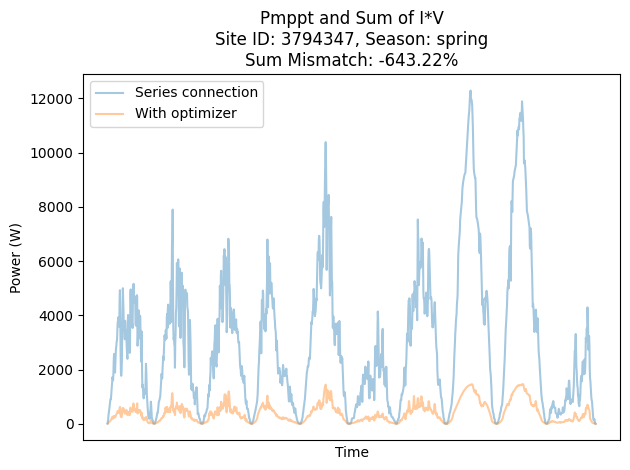

In [ ]:
# Merge the pmppt_data with the iv_sum_data
combined_data = pd.concat([iv_sum_data, pmppt_data['Pmppt (W)']], axis=1)

# Add season and site ID columns to the combined data
combined_data['Season'] = season
combined_data['Site ID'] = site_id

# Export the combined data to an Excel file with season and site ID in the file name
excel_file = os.path.join(output_dir, f'combined_data_{season}_{site_id}.xlsx')
combined_data.to_excel(excel_file, index=False)

print(f"Combined data exported to: {excel_file}")

# Calculate the total energy of Sum of I*V and Pmppt
sum_iv_E = combined_data['Sum of I*V (W)'].sum()
pmppt_E = combined_data['Pmppt (W)'].sum()
sum_mismatch = (sum_iv_E - pmppt_E) / sum_iv_E

# Check if the lengths of Sum of I*V and Pmppt are the same
if len(combined_data['Sum of I*V (W)']) == len(combined_data['Pmppt (W)']):
    print("The lengths of Sum of I*V and Pmppt are the same.")
else:
    print("Warning: The lengths of Sum of I*V and Pmppt are not the same!")

# Print the total energy for both
print(f"Sum of I*V Energy: {sum_iv_E:.2f} W")
print(f"Pmppt Energy: {pmppt_E:.2f} W")

# Print the mean mismatch in percentage with 2 decimal places
print(f"Sum mismatch: {sum_mismatch * 100:.2f}%")

# Plot the Pmppt and Sum of I*V
fig, ax = plt.subplots()
ax.plot(combined_data['Timestamp'], combined_data['Pmppt (W)'], label='Series connection', alpha=0.4)
ax.plot(combined_data['Timestamp'], combined_data['Sum of I*V (W)'], label='With optimizer', alpha=0.4)
ax.set_xlabel('Time')
ax.set_ylabel('Power (W)')
# Include season and site ID in the title
ax.set_title(f'Pmppt and Sum of I*V\nSite ID: {site_id}, Season: {season}\nSum Mismatch: {sum_mismatch * 100:.2f}%')
ax.legend()
# Remove xticks
ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
plt.tight_layout()

# Save the plot to a PNG file
plot_file = os.path.join(output_dir, 'pmppt_vs_sum_iv.png')
fig.savefig(plot_file)
print(f"Plot exported to: {plot_file}")

plt.show()

### 3.1.2. Aggregate over each day

Date: 2024-09-20
Maximum IV Power: 751.64 W (Exceeds 3000 W: False)
Daily Energy MPPT: 29442.88 Wh
Daily Energy IV: 3723.07 Wh
Daily Mismatch: -690.82%

Plot saved for 2024-09-20: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined/iv_curve_plots_20250405_200022_spring_3794347\Daily_Comparison_for_2024-09-20_Site_ID_3794347_Season_spring_E_MPPT_2944288_Wh_E_IV_372307_Wh_Max_IV_Power_75164_W_Mismatch_-69082.png



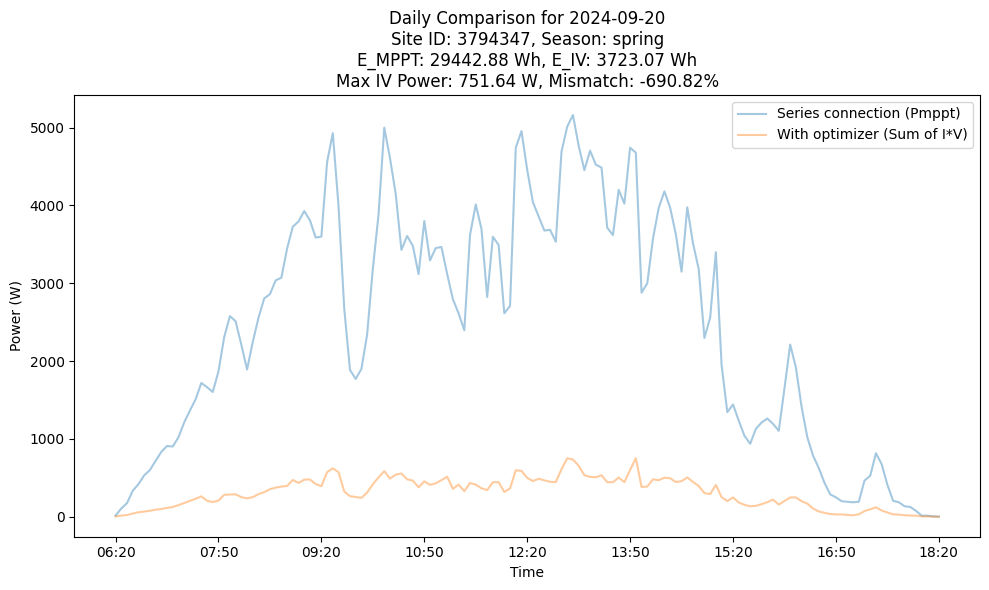

Date: 2024-09-21
Maximum IV Power: 1131.50 W (Exceeds 3000 W: False)
Daily Energy MPPT: 32409.65 Wh
Daily Energy IV: 4209.17 Wh
Daily Mismatch: -669.98%

Plot saved for 2024-09-21: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined/iv_curve_plots_20250405_200022_spring_3794347\Daily_Comparison_for_2024-09-21_Site_ID_3794347_Season_spring_E_MPPT_3240965_Wh_E_IV_420917_Wh_Max_IV_Power_113150_W_Mismatch_-66998.png



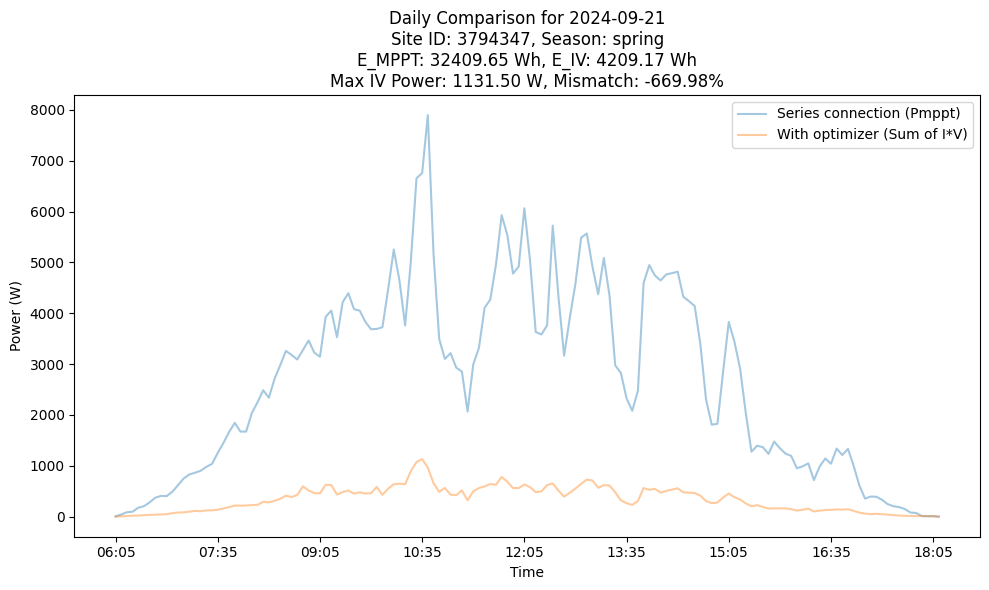

Date: 2024-09-22
Maximum IV Power: 1194.17 W (Exceeds 3000 W: False)
Daily Energy MPPT: 33460.89 Wh
Daily Energy IV: 4663.81 Wh
Daily Mismatch: -617.46%

Plot saved for 2024-09-22: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined/iv_curve_plots_20250405_200022_spring_3794347\Daily_Comparison_for_2024-09-22_Site_ID_3794347_Season_spring_E_MPPT_3346089_Wh_E_IV_466381_Wh_Max_IV_Power_119417_W_Mismatch_-61746.png



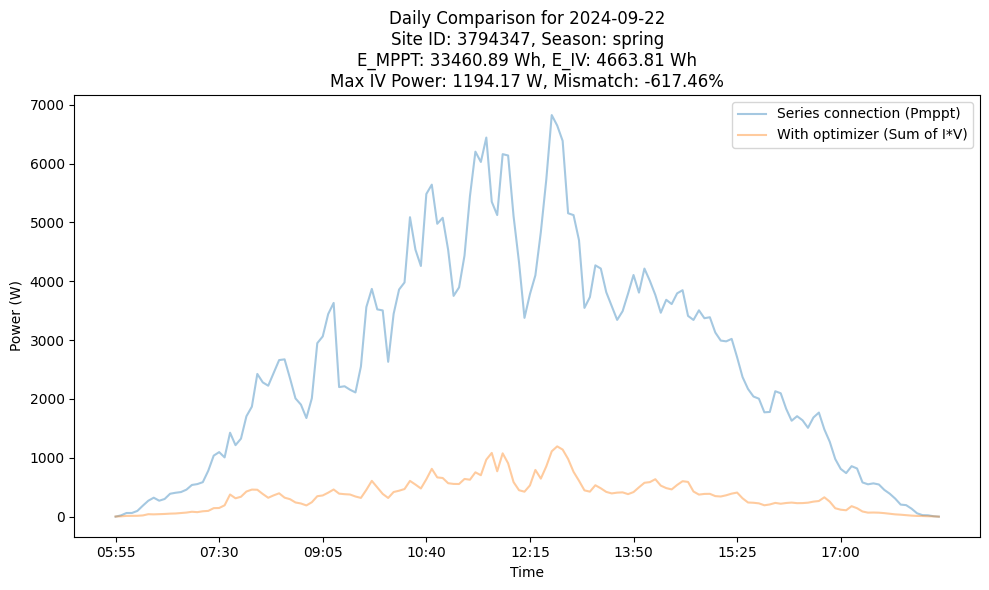

Date: 2024-09-23
Maximum IV Power: 1035.69 W (Exceeds 3000 W: False)
Daily Energy MPPT: 27831.28 Wh
Daily Energy IV: 3739.87 Wh
Daily Mismatch: -644.18%

Plot saved for 2024-09-23: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined/iv_curve_plots_20250405_200022_spring_3794347\Daily_Comparison_for_2024-09-23_Site_ID_3794347_Season_spring_E_MPPT_2783128_Wh_E_IV_373987_Wh_Max_IV_Power_103569_W_Mismatch_-64418.png



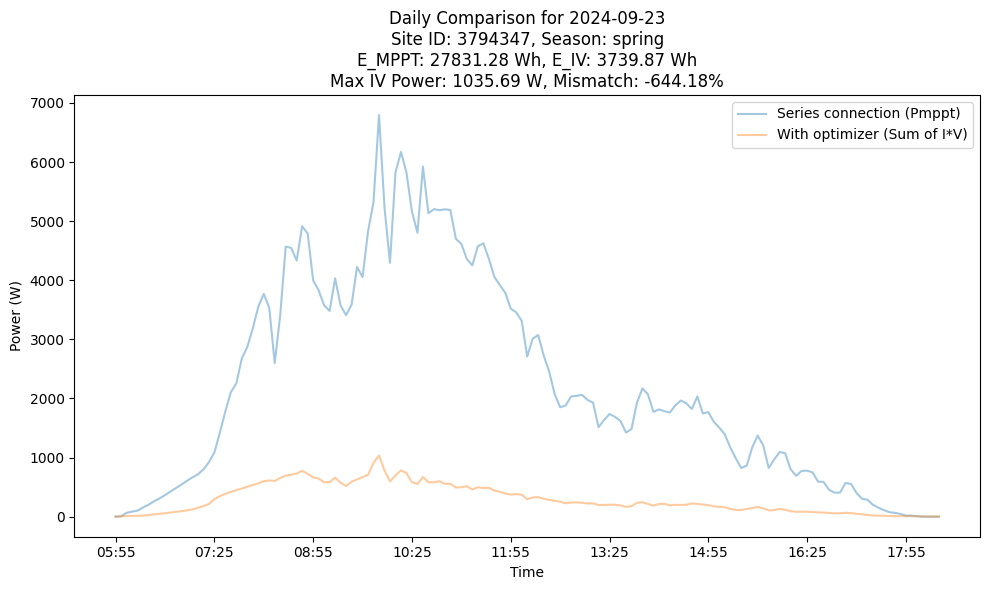

Date: 2024-09-24
Maximum IV Power: 1444.73 W (Exceeds 3000 W: False)
Daily Energy MPPT: 46387.15 Wh
Daily Energy IV: 6334.94 Wh
Daily Mismatch: -632.24%

Plot saved for 2024-09-24: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined/iv_curve_plots_20250405_200022_spring_3794347\Daily_Comparison_for_2024-09-24_Site_ID_3794347_Season_spring_E_MPPT_4638715_Wh_E_IV_633494_Wh_Max_IV_Power_144473_W_Mismatch_-63224.png



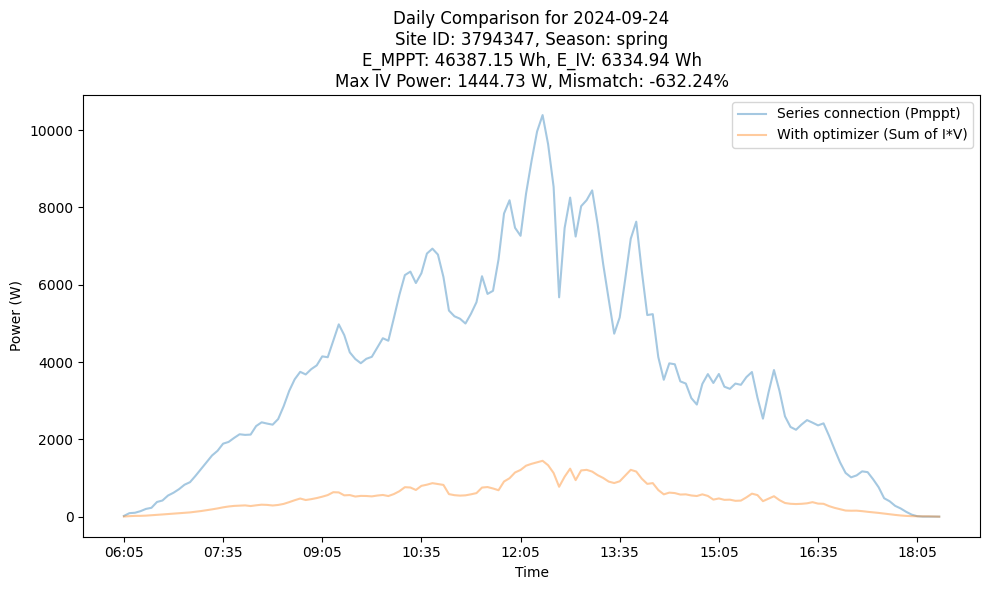

Date: 2024-09-25
Maximum IV Power: 452.65 W (Exceeds 3000 W: False)
Daily Energy MPPT: 14856.43 Wh
Daily Energy IV: 1803.66 Wh
Daily Mismatch: -723.68%

Plot saved for 2024-09-25: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined/iv_curve_plots_20250405_200022_spring_3794347\Daily_Comparison_for_2024-09-25_Site_ID_3794347_Season_spring_E_MPPT_1485643_Wh_E_IV_180366_Wh_Max_IV_Power_45265_W_Mismatch_-72368.png



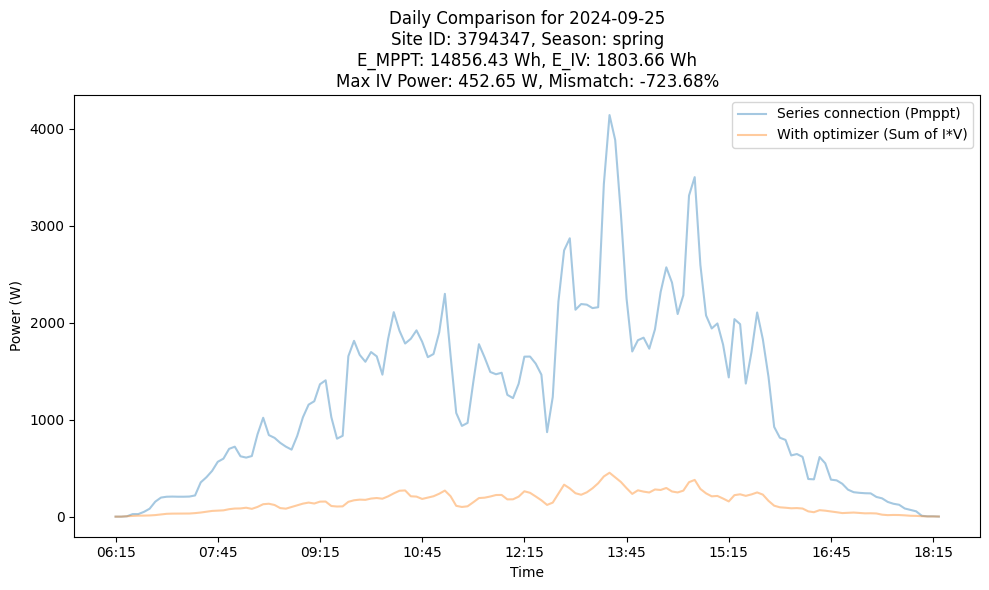

Date: 2024-09-26
Maximum IV Power: 1022.40 W (Exceeds 3000 W: False)
Daily Energy MPPT: 40777.56 Wh
Daily Energy IV: 5282.17 Wh
Daily Mismatch: -671.99%

Plot saved for 2024-09-26: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined/iv_curve_plots_20250405_200022_spring_3794347\Daily_Comparison_for_2024-09-26_Site_ID_3794347_Season_spring_E_MPPT_4077756_Wh_E_IV_528217_Wh_Max_IV_Power_102240_W_Mismatch_-67199.png



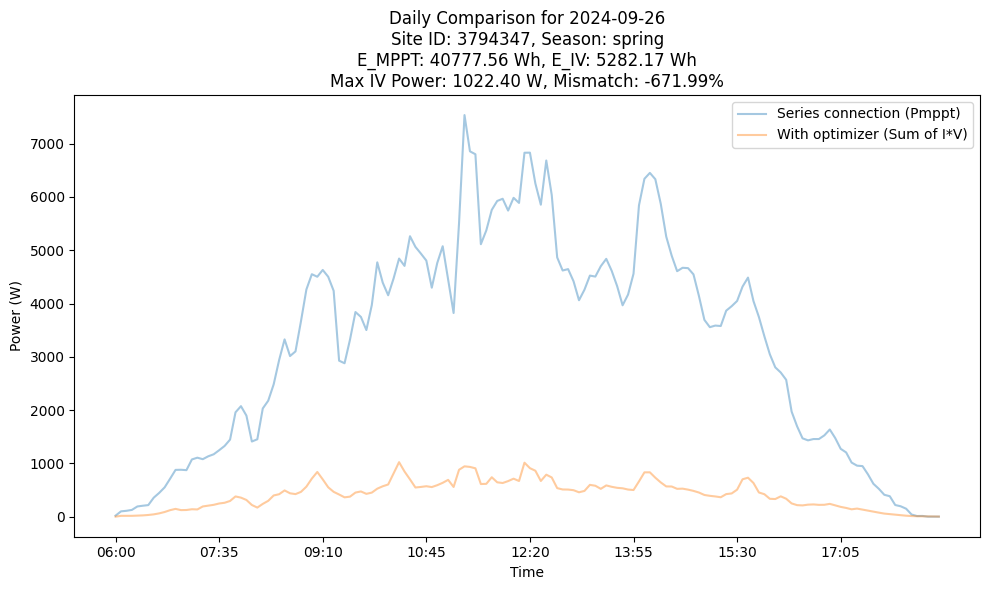

Date: 2024-09-27
Maximum IV Power: 1457.82 W (Exceeds 3000 W: False)
Daily Energy MPPT: 68998.80 Wh
Daily Energy IV: 9453.93 Wh
Daily Mismatch: -629.84%

Plot saved for 2024-09-27: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined/iv_curve_plots_20250405_200022_spring_3794347\Daily_Comparison_for_2024-09-27_Site_ID_3794347_Season_spring_E_MPPT_6899880_Wh_E_IV_945393_Wh_Max_IV_Power_145782_W_Mismatch_-62984.png



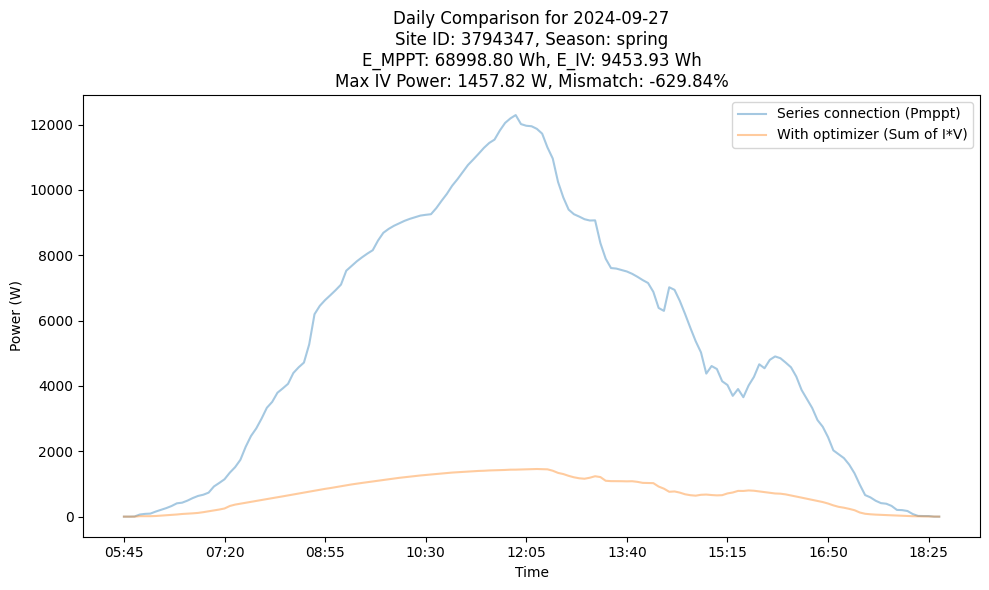

Date: 2024-09-28
Maximum IV Power: 1466.07 W (Exceeds 3000 W: False)
Daily Energy MPPT: 67476.04 Wh
Daily Energy IV: 9334.64 Wh
Daily Mismatch: -622.86%

Plot saved for 2024-09-28: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined/iv_curve_plots_20250405_200022_spring_3794347\Daily_Comparison_for_2024-09-28_Site_ID_3794347_Season_spring_E_MPPT_6747604_Wh_E_IV_933464_Wh_Max_IV_Power_146607_W_Mismatch_-62286.png



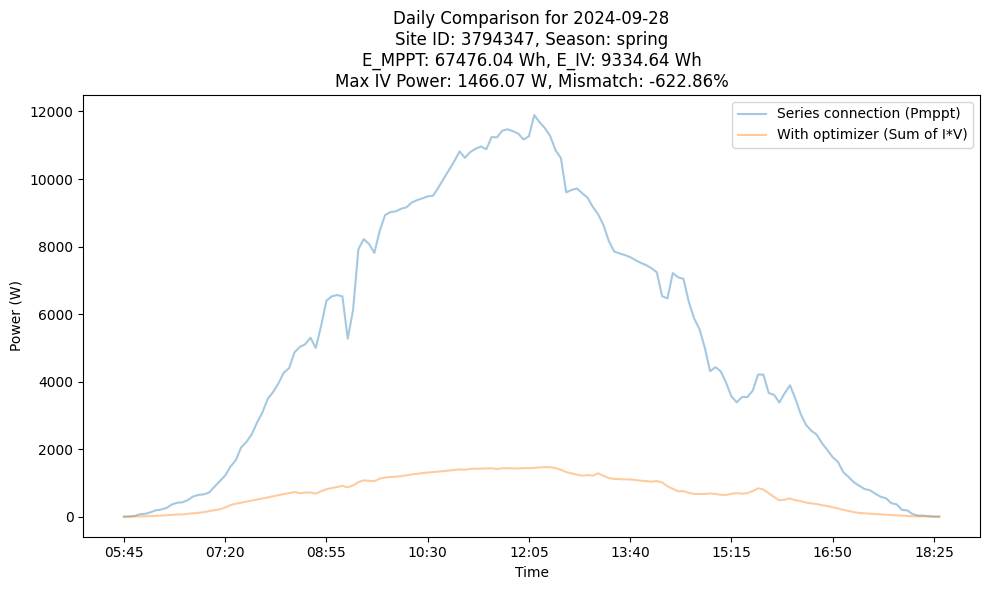

Date: 2024-09-29
Maximum IV Power: 704.56 W (Exceeds 3000 W: False)
Daily Energy MPPT: 14233.48 Wh
Daily Energy IV: 2028.78 Wh
Daily Mismatch: -601.58%

Plot saved for 2024-09-29: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined/iv_curve_plots_20250405_200022_spring_3794347\Daily_Comparison_for_2024-09-29_Site_ID_3794347_Season_spring_E_MPPT_1423348_Wh_E_IV_202878_Wh_Max_IV_Power_70456_W_Mismatch_-60158.png



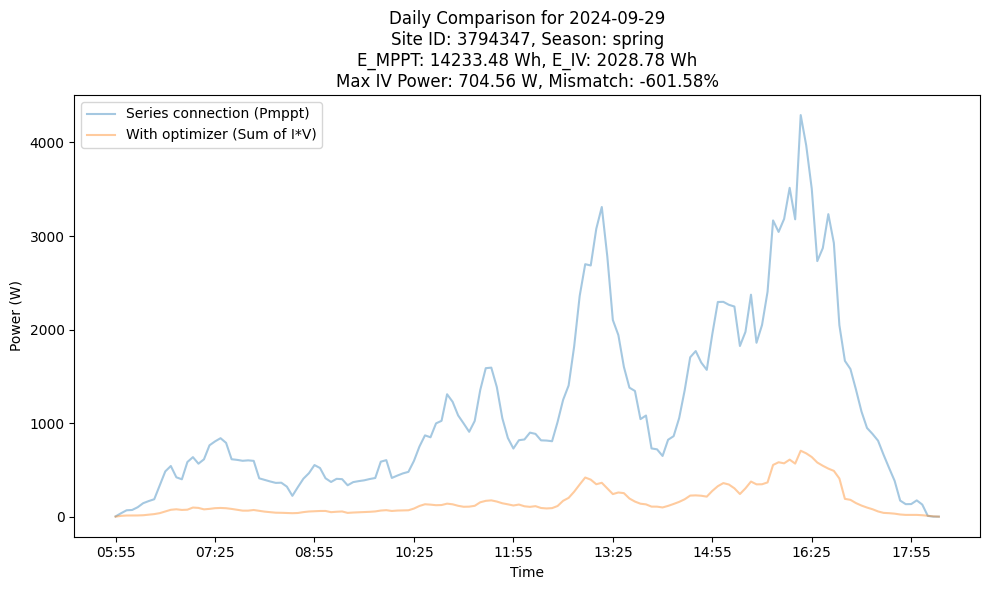

Weighted Average Daily Mismatch: -643.22%


In [ ]:
# perform filter
perform_filter = False

# Ensure Timestamp is in datetime format
combined_data['Timestamp'] = pd.to_datetime(combined_data['Timestamp'])

# Add a Date column to group by day
combined_data['Date'] = combined_data['Timestamp'].dt.date

# Calculate daily energy (convert power to energy in Wh)
combined_data['Energy_IV (Wh)'] = combined_data['Sum of I*V (W)'] * (5 / 60)  # Convert 5-min data to Wh
combined_data['Energy_MPPT (Wh)'] = combined_data['Pmppt (W)'] * (5 / 60)

# Group by date and calculate daily sums
daily_data = combined_data.groupby('Date')[['Energy_IV (Wh)', 'Energy_MPPT (Wh)']].sum()

# Initialize variables for weighted average calculation
weighted_sum_difference = 0
total_energy = 0

import re  # To clean title text for file names

# Iterate over each day to calculate differences, check conditions, and plot
for date, daily_row in daily_data.iterrows():
    energy_iv_daily = daily_row['Energy_IV (Wh)']
    energy_mppt_daily = daily_row['Energy_MPPT (Wh)']

    # Calculate daily mismatch
    daily_mismatch = (energy_iv_daily - energy_mppt_daily) / energy_iv_daily

    # Filter data for the current day
    day_data = combined_data[combined_data['Date'] == date]

    # Calculate the maximum IV power for the day
    max_iv_power = day_data['Sum of I*V (W)'].max()

    # Only include days with max IV power > 3000 W in weighted mismatch calculation
    if perform_filter:
        if max_iv_power > 3000:
            weighted_sum_difference += daily_mismatch * energy_iv_daily  # Weight by daily energy
            total_energy += energy_iv_daily  # Use IV energy for weighting
    else:
        weighted_sum_difference += daily_mismatch * energy_iv_daily  # Weight by daily energy
        total_energy += energy_iv_daily  # Use IV energy for weighting

    # Log results
    exceeds_3000W = max_iv_power > 3000
    print(f"Date: {date}")
    print(f"Maximum IV Power: {max_iv_power:.2f} W (Exceeds 3000 W: {exceeds_3000W})")
    print(f"Daily Energy MPPT: {energy_mppt_daily:.2f} Wh")
    print(f"Daily Energy IV: {energy_iv_daily:.2f} Wh")
    print(f"Daily Mismatch: {daily_mismatch * 100:.2f}%\n")

    # Plot the comparison for the day
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(day_data['Timestamp'], day_data['Pmppt (W)'], label='Series connection (Pmppt)', alpha=0.4)
    ax.plot(day_data['Timestamp'], day_data['Sum of I*V (W)'], label='With optimizer (Sum of I*V)', alpha=0.4)
    ax.set_xlabel('Time')
    ax.set_ylabel('Power (W)')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # Format x-axis as hours
    ax.set_xticks(day_data['Timestamp'][::len(day_data) // 8])  # Set fewer ticks on x-axis

    # Include daily details in the title
    plot_title = (
        f"Daily Comparison for {date}\n"
        f"Site ID: {site_id}, Season: {season}\n"
        f"E_MPPT: {energy_mppt_daily:.2f} Wh, E_IV: {energy_iv_daily:.2f} Wh\n"
        f"Max IV Power: {max_iv_power:.2f} W, Mismatch: {daily_mismatch * 100:.2f}%"
    )
    ax.set_title(plot_title)
    ax.legend()
    plt.tight_layout()

    # Generate a safe file name from the title
    safe_title = re.sub(r'[^\w\s-]', '', plot_title).replace(' ', '_').replace('\n', '_')
    plot_file = os.path.join(output_dir, f"{safe_title}.png")

    # Save the plot for each day
    fig.savefig(plot_file)
    print(f"Plot saved for {date}: {plot_file}\n")

    plt.show()

# Calculate the weighted average of daily percentage differences
weighted_avg_mismatch = weighted_sum_difference / total_energy

# Print the weighted average mismatch
print(f"Weighted Average Daily Mismatch: {weighted_avg_mismatch * 100:.2f}%")


## 3.2. Check by timestamp

In [ ]:
# # input the timestamp to check
# timestamp = '2024-01-19 11:20:00'

# # extract the Pmppt and I*V sum for the timestamp from the combined data
# pmppt = combined_data.loc[combined_data['Timestamp'] == timestamp, 'Pmppt (W)'].values[0]
# sum_iv = combined_data.loc[combined_data['Timestamp'] == timestamp, 'Sum of I*V (W)'].values[0]

# # calculate the mismatch
# mismatch = 1 - pmppt / sum_iv

# # print the result
# print(f"Timestamp: {timestamp}")
# print(f"Pmppt: {pmppt:.2f} W")
# print(f"Sum of I*V: {sum_iv:.2f} W")
# print(f"Mismatch: {mismatch * 100:.2f}%")


# 4. J0 investigation

Contents of C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\iv_curve_plots_20250404_211059_spring_3794347\j0_data.csv:
             Timestamp     241622243     241622244     241622246  \
0  2024-09-20 06:20:00           NaN           NaN           NaN   
1  2024-09-20 06:25:00  4.206835e-07  4.765787e-07           NaN   
2  2024-09-20 06:30:00  6.202073e-07  5.758856e-07  4.391310e-07   
3  2024-09-20 06:35:00  6.514877e-07  6.563564e-07  5.979259e-07   
4  2024-09-20 06:40:00  9.017376e-07  7.331440e-07  7.189949e-07   

      241622247     241622248     241622249     241622250     241622251  \
0           NaN           NaN           NaN           NaN           NaN   
1  5.954272e-07  6.549261e-07  4.764211e-07  4.377795e-07  4.287579e-07   
2  9.594930e-07  7.887930e-07  5.674162e-07  3.977095e-07  4.871438e-07   
3  1.082007e-06  7.119612e-07  7.848429e-07  5.563075e-07  5.678056e-07   
4  1.000898e-06  8.455288e-07  8.758233e-07  5.788924e-07  6.387

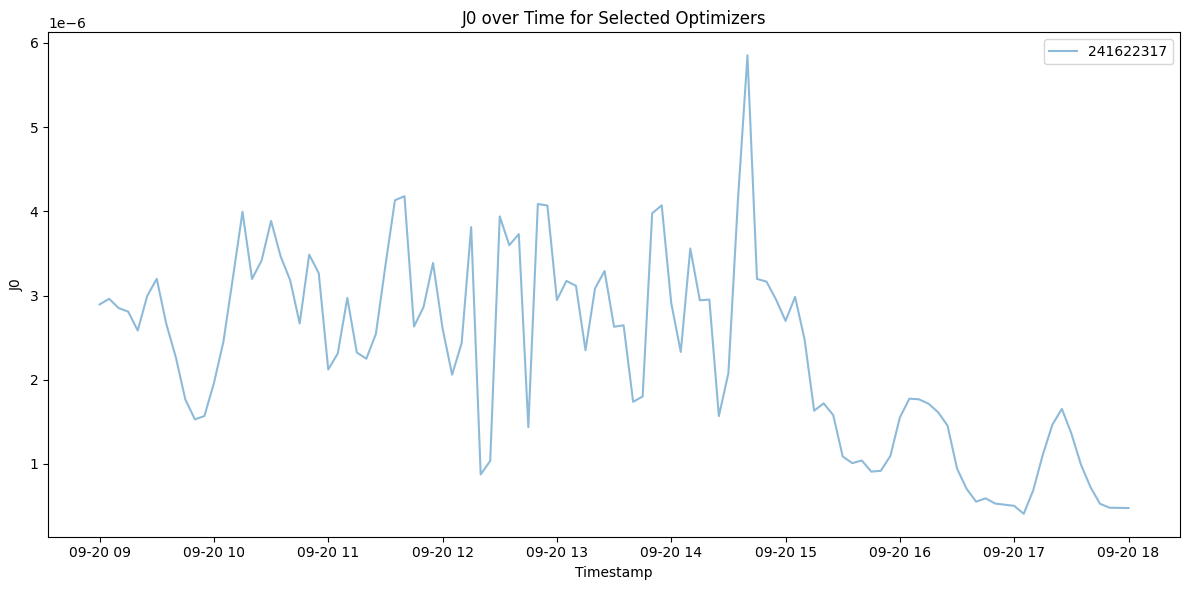

In [ ]:
# ============================
# Input Parameters
# ============================
# Directory where the J0 CSV file is located
# results_dir = r'C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\iv_curve_plots_20250404_211059_spring_3794347'

# Adjustable date range in 'YYYY-MM-DD' format (set to None to disable filtering)
start_date = '2024-09-20 9:00'
end_date   = '2024-09-20 18:59'



# Define which optimizers to plot (list of column names). If None, all optimizer data will be plotted.
selected_optimizers = ['241622317']  # Example: ['optimizer1', 'optimizer2']
# selected_optimizers = ['241622317']  # Example: ['optimizer1', 'optimizer2']
# selected_optimizers = None  # Set to None to plot all optimizers
# ============================

# Look for CSV files whose name contains 'J0' or 'j0'
j0_files = [f for f in os.listdir(results_dir) if (('J0' in f) or ('j0' in f)) and f.endswith('.csv')]

# Check if there are any files found
if not j0_files:
    print("No J0 files found in the results directory.")
else:
    # Read the first file found
    j0_file = os.path.join(results_dir, j0_files[0])
    try:
        j0_df = pd.read_csv(j0_file, encoding='utf-8')
    except UnicodeDecodeError:
        print("UTF-8 encoding failed, trying latin1 encoding.")
        j0_df = pd.read_csv(j0_file, encoding='latin1')

    # Check the contents of the file
    print(f"Contents of {j0_file}:")
    print(j0_df.head())
    print(f"Number of rows: {len(j0_df)}")

    # Convert the Timestamp column to datetime and set it as the index, if available
    if 'Timestamp' in j0_df.columns:
        j0_df['Timestamp'] = pd.to_datetime(j0_df['Timestamp'])
        j0_df.set_index('Timestamp', inplace=True)
    else:
        j0_df.index = pd.to_datetime(j0_df.index)
    
    # Filter the DataFrame by date range if provided
    if start_date is not None:
        j0_df = j0_df[j0_df.index >= pd.to_datetime(start_date)]
    if end_date is not None:
        j0_df = j0_df[j0_df.index <= pd.to_datetime(end_date)]
    
    # Filter columns if specific optimizers are defined
    if selected_optimizers is not None:
        # Ensure only existing columns are used
        selected_columns = [opt for opt in selected_optimizers if opt in j0_df.columns]
        j0_df = j0_df[selected_columns]
    
    # Plot the data without legends
    plt.figure(figsize=(12, 6))
    for col in j0_df.columns:
        plt.plot(j0_df.index, j0_df[col], label=col, alpha=0.5)
    plt.xlabel('Timestamp')
    plt.ylabel('J0')
    plt.title('J0 over Time for Selected Optimizers')
    plt.legend()
    plt.tight_layout()
    plt.show()
